##### Import Libraries

In [64]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.mstats import winsorize
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.api import ExponentialSmoothing as ES
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot
import seaborn as sns
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [2]:
# Load the dataset
data = pd.read_csv('D:\Essex\Dissertation\Bedallocation\project\Time_Series_Forecasting_MS-main\src\Data\historic_admissions.csv')


In [3]:
# Parse the 'ADMIT_DTTM' column as datetime
data['ADMIT_DTTM'] = pd.to_datetime(data['ADMIT_DTTM'])

# Extract year, month, and day
data['Year'] = data['ADMIT_DTTM'].dt.year
data['Month'] = data['ADMIT_DTTM'].dt.month
data['Day'] = data['ADMIT_DTTM'].dt.day

# Set the 'ADMIT_DTTM' as the index
data.set_index('ADMIT_DTTM', inplace=True)

# Resample the data to weekly frequency, summing up the totals
weekly_data = data.resample('W').sum()

# Perform log transformation
import numpy as np
weekly_data['Log_Total'] = np.log1p(weekly_data['Total'])

# Dropping the 'Unnamed: 0' column
weekly_data.drop(columns='Unnamed: 0', inplace=True)

# Display the transformed data
weekly_data.head()

Unnamed: 0  Total    Year  Month   Day  Log_Total
ADMIT_DTTM                                                   
1855-01-07       14028   3863  311640    168   672   8.259458
1855-01-14       42252   3789  311640    168  1848   8.240121
1855-01-21       70476   3901  311640    168  3024   8.269245
1855-01-28       98700   3865  311640    168  4200   8.259976
1855-02-04      126924   3737  311640    264  2400   8.226306

In [ ]:
# Sort the data by index (ADMIT_DTTM)
data.sort_index(inplace=True)

In [ ]:
# Data types and range of dates
data_types = data.dtypes
date_range = [data.index.min(), data.index.max()]

# Basic statistics
summary_statistics = data.describe()

# Check for missing data
missing_data = data.isnull().sum()

data_types, date_range, summary_statistics, missing_data

In [ ]:
# Handle missing values, if necessary
# For example, forward fill
data.fillna(method='ffill', inplace=True)

In [ ]:
# Remove duplicates
data = data[~data.index.duplicated(keep='first')]

##### Basic Analysis

In [ ]:
#Daily Pattern Analysis:
#Investigate any daily patterns, like peaks or troughs during certain days of the month.
daily_pattern = data.groupby(data.index.day).mean()
plt.figure(figsize=(12, 6))
plt.plot(daily_pattern['Total'], marker='o')
plt.title('Daily Admission Patterns')
plt.xlabel('Day of the Month')
plt.ylabel('Average Total Admissions')
plt.grid(True)
plt.show()


In [ ]:
#Comparison of Monthly Trends Across Different Years:
#This allows you to see how specific months compare across different years.
data['Year'] = data.index.year
data['Month'] = data.index.month
monthly_trends = data.pivot_table(values='Total', index='Month', columns='Year', aggfunc='mean')
plt.figure(figsize=(12, 6))
sns.heatmap(monthly_trends, annot=True, fmt=".0f", cmap='YlGnBu')
plt.title('Monthly Admission Trends Across Years')
plt.ylabel('Month')
plt.xlabel('Year')
plt.show()


In [44]:
# Monthly Analysis: Finding the month with the highest number of admissions

# Grouping by Year and Month to sum the total admissions
monthly_admissions = data.groupby(['Year', 'Month'])['Total'].sum()
highest_month = monthly_admissions.idxmax(), monthly_admissions.max()

highest_month

((1861, 8), 17225)

##### Converting to weekly frequency

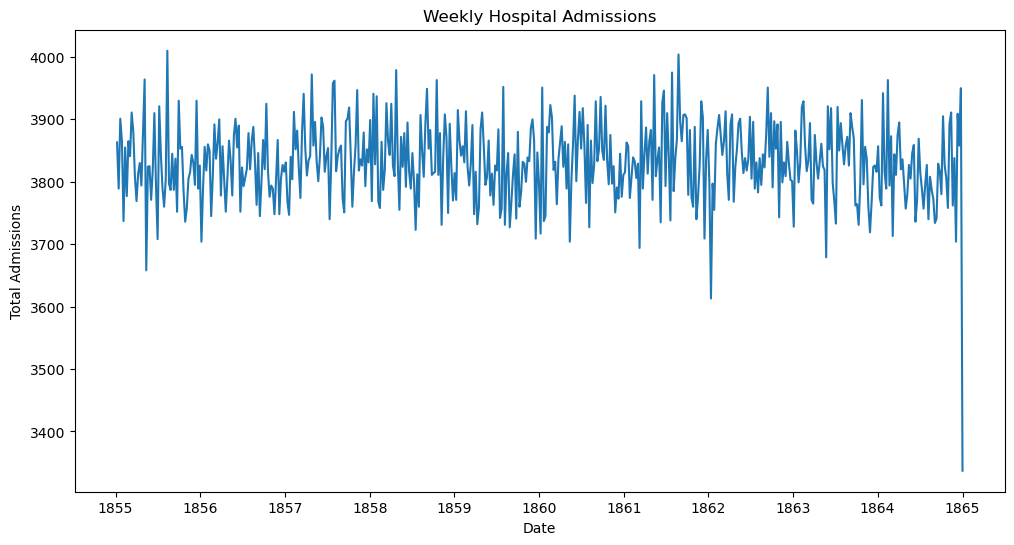

Unnamed: 0  Total    Year  Month   Day
ADMIT_DTTM                                        
1855-01-07       14028   3863  311640    168   672
1855-01-14       42252   3789  311640    168  1848
1855-01-21       70476   3901  311640    168  3024
1855-01-28       98700   3865  311640    168  4200
1855-02-04      126924   3737  311640    264  2400

In [45]:
# Resampling the data to a weekly frequency
weekly_data = data.resample('W').sum()

# Plotting the weekly resampled time series
plt.figure(figsize=(12, 6))
plt.plot(weekly_data.index, weekly_data['Total'])
plt.title('Weekly Hospital Admissions')
plt.xlabel('Date')
plt.ylabel('Total Admissions')
plt.show()

weekly_data.head()


##### Wavelet Transform

D:\Anaconda3\lib\site-packages\pywt\_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


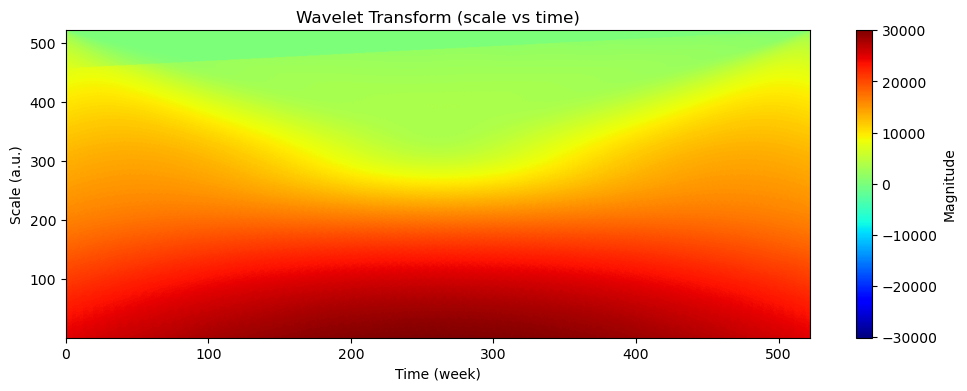

In [42]:
import pywt
# Prepare the data for Wavelet Transform
signal = weekly_data['Total'].values
scales = np.arange(1, len(signal) + 1)

# Perform the Continuous Wavelet Transform (CWT)
coefficients, frequencies = pywt.cwt(signal, scales, 'cmor')

# Plot the wavelet transform result
plt.figure(figsize=(12, 4))
plt.imshow(np.abs(coefficients), extent=[0, len(signal), 1, max(scales)], cmap='jet', aspect='auto',
           vmax=abs(coefficients).max(), vmin=-abs(coefficients).max())
plt.colorbar(label='Magnitude')
plt.title('Wavelet Transform (scale vs time)')
plt.ylabel('Scale (a.u.)')
plt.xlabel('Time (week)')
plt.show()

##### Seasonal Decomposition

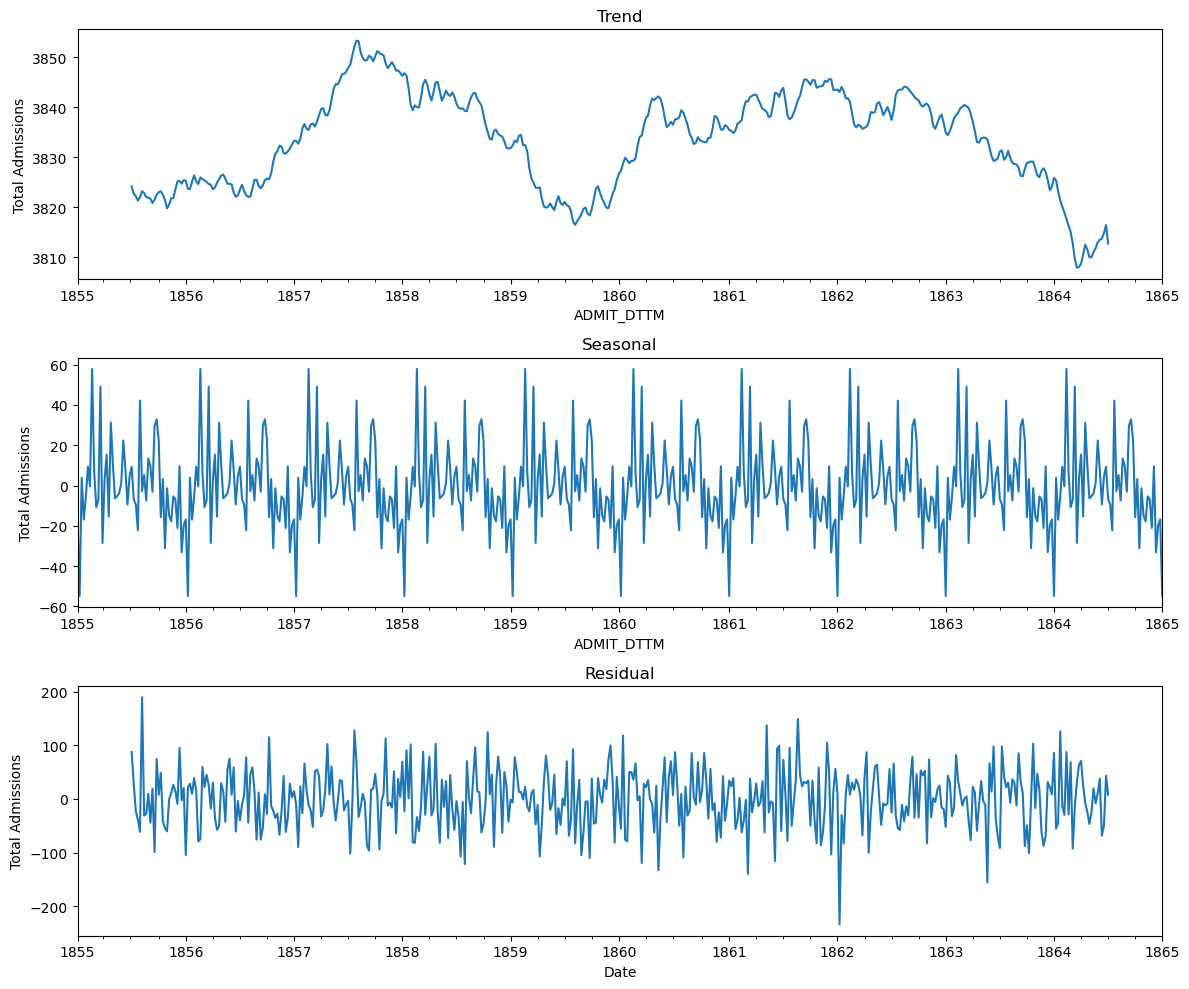

In [41]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
decomposition = seasonal_decompose(weekly_data['Total'], model='additive')

# Plot the decomposed components
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))
decomposition.trend.plot(ax=ax1)
ax1.set_title('Trend')
ax1.set_ylabel('Total Admissions')

decomposition.seasonal.plot(ax=ax2)
ax2.set_title('Seasonal')
ax2.set_ylabel('Total Admissions')

decomposition.resid.plot(ax=ax3)
ax3.set_title('Residual')
ax3.set_xlabel('Date')
ax3.set_ylabel('Total Admissions')

plt.tight_layout()
plt.show()


##### Checking outliers

In [26]:
# Recalculating outliers directly from the log-transformed weekly data (without using residuals)

# Calculate IQR for the log-transformed data
Q1_log_direct = weekly_data['Total'].quantile(0.25)
Q3_log_direct = weekly_data['Total'].quantile(0.75)
IQR_log_direct = Q3_log_direct - Q1_log_direct

# Determine outliers in the 'Total' column
outliers_log_direct = weekly_data['Total'][
    (weekly_data['Total'] < (Q1_log_direct - 1.5 * IQR_log_direct)) | 
    (weekly_data['Total'] > (Q3_log_direct + 1.5 * IQR_log_direct))
]

# Description of direct outliers
outliers_log_direct_description = outliers_log_direct.describe()

outliers_log_direct_description, outliers_log_direct.head()


(count       5.000000
 mean     3724.400000
 std       285.762664
 min      3337.000000
 25%      3613.000000
 50%      3658.000000
 75%      4004.000000
 max      4010.000000
 Name: Total, dtype: float64,
 ADMIT_DTTM
 1855-05-13    3658
 1855-08-12    4010
 1861-08-25    4004
 1862-01-12    3613
 1865-01-01    3337
 Name: Total, dtype: int64)

In [27]:
# Calculate skewness of the 'Total' column in the original dataset
skewness_value = weekly_data['Total'].skew()

skewness_value


-0.8357317527483439

In [15]:
#log transform
weekly_data_log = weekly_data.copy()

# Apply logarithmic transformation to the 'Total' column
weekly_data_log['Log_Total'] = np.log(weekly_data['Total'])

weekly_data_log.head()

Total    Year  Month   Day  Log_Total
ADMIT_DTTM                                       
1855-01-07   3863  311640    168   672   8.259199
1855-01-14   3789  311640    168  1848   8.239857
1855-01-21   3901  311640    168  3024   8.268988
1855-01-28   3865  311640    168  4200   8.259717
1855-02-04   3737  311640    264  2400   8.226038

In [28]:
# Calculate skewness of the 'Total' column in the original dataset
skewness_value = weekly_data_log['Log_Total'].skew()

skewness_value


-1.047757777864208

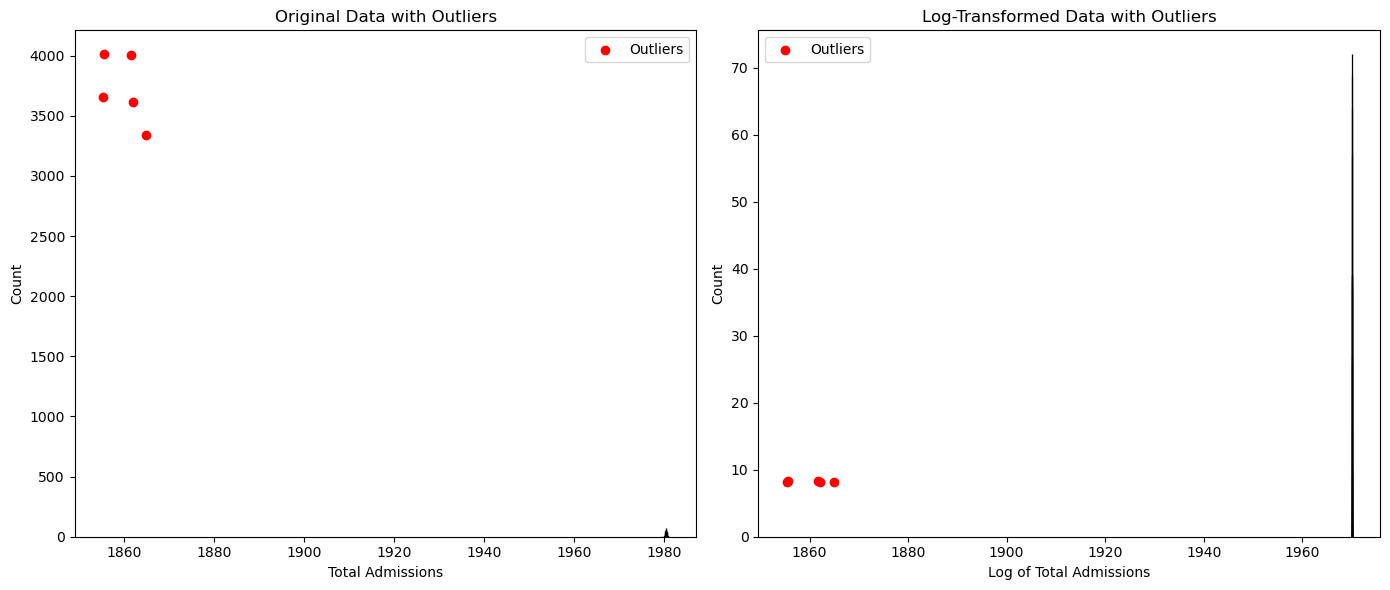

In [29]:


# Assuming 'weekly_data' is your DataFrame with the original total admissions
# and 'weekly_data_log' is your DataFrame with the log-transformed total admissions.

# Calculate IQR for the original data
Q1 = weekly_data['Total'].quantile(0.25)
Q3 = weekly_data['Total'].quantile(0.75)
IQR = Q3 - Q1

# Determine outliers in the original data
outliers = weekly_data[(weekly_data['Total'] < (Q1 - 1.5 * IQR)) | (weekly_data['Total'] > (Q3 + 1.5 * IQR))]

# Calculate IQR for the log-transformed data
Q1_log = weekly_data_log['Log_Total'].quantile(0.25)
Q3_log = weekly_data_log['Log_Total'].quantile(0.75)
IQR_log = Q3_log - Q1_log

# Determine outliers in the log-transformed data
outliers_log = weekly_data_log[(weekly_data_log['Log_Total'] < (Q1_log - 1.5 * IQR_log)) | (weekly_data_log['Log_Total'] > (Q3_log + 1.5 * IQR_log))]

# Setting up the plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plotting original data with outliers highlighted
sns.histplot(weekly_data['Total'], kde=False, ax=axes[0])
axes[0].scatter(outliers.index, outliers['Total'], color='red', label='Outliers')
axes[0].set_title('Original Data with Outliers')
axes[0].set_xlabel('Total Admissions')
axes[0].set_ylabel('Count')

# Plotting log-transformed data with outliers highlighted
sns.histplot(weekly_data_log['Log_Total'], kde=False, ax=axes[1])
axes[1].scatter(outliers_log.index, outliers_log['Log_Total'], color='red', label='Outliers')
axes[1].set_title('Log-Transformed Data with Outliers')
axes[1].set_xlabel('Log of Total Admissions')

# Show the legend
for ax in axes:
    ax.legend()

plt.tight_layout()
plt.show()


##### Creating new dataframe without outliers

In [46]:

data_without_outliers = weekly_data[~weekly_data.index.isin(outliers_log_direct.index)]

In [32]:

skewness_value = data_without_outliers['Total'].skew()

skewness_value


0.07960609326534979

##### Checking normal distribution for  weekly_data, weekly_data_log and data_without_outliers

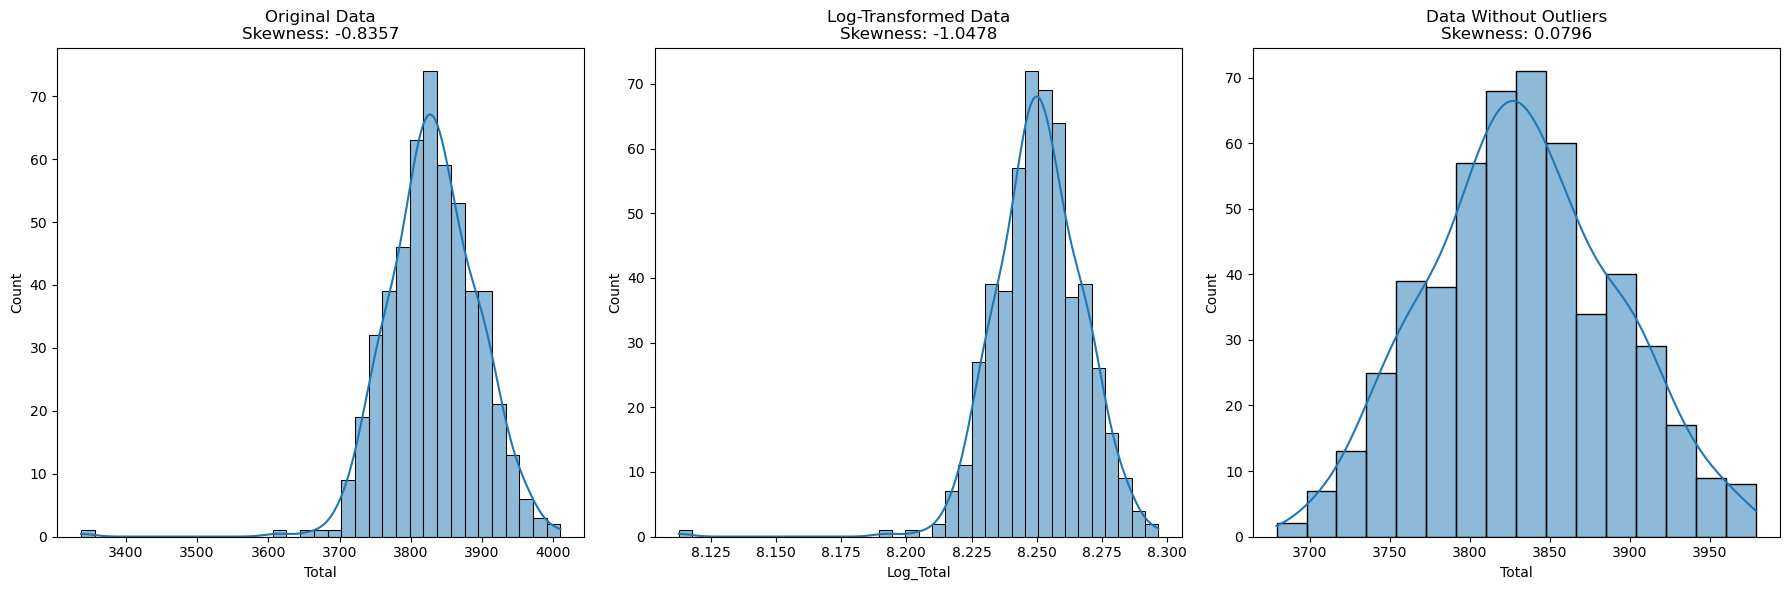

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original data plot
sns.histplot(weekly_data['Total'], kde=True, ax=axes[0])
axes[0].set_title(f"Original Data\nSkewness: {weekly_data['Total'].skew():.4f}")

# Log-transformed data plot
sns.histplot(weekly_data_log['Log_Total'], kde=True, ax=axes[1])  # Assuming weekly_data_log is a Series
axes[1].set_title(f"Log-Transformed Data\nSkewness: {weekly_data_log['Log_Total'].skew():.4f}")

# Data without outliers plot
sns.histplot(data_without_outliers['Total'], kde=True, ax=axes[2])
axes[2].set_title(f"Data Without Outliers\nSkewness: {data_without_outliers['Total'].skew():.4f}")

plt.tight_layout()
plt.show()


##### Augmented Dickey-Fuller test

In [36]:

adf_result = adfuller(data_without_outliers['Total'].dropna())

# Extracting the test results
adf_statistic = adf_result[0]
adf_p_value = adf_result[1]
adf_critical_values = adf_result[4]

adf_statistic, adf_p_value, adf_critical_values


(-23.03176085868034,
 0.0,
 {'1%': -3.443086684769254,
  '5%': -2.867157550015396,
  '10%': -2.5697619453458325})

##### Required functions

In [37]:
# Function to evaluate the forecast


def evaluate_forecast(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    
    # Calculate naive forecast (shift actual by 1 time step)
    naive_forecast = np.roll(actual, shift=1)
    naive_forecast[0] = actual[0]  # Replace the first value with the actual value
    
    # Calculate Mean Absolute Scaled Error (MASE)
    mase = np.mean(np.abs(actual - predicted) / np.abs(actual - naive_forecast))
    
    # Calculate R-squared (R²)
    total_variance = np.sum((actual - np.mean(actual)) ** 2)
    explained_variance = np.sum((predicted - actual) ** 2)
    r_squared = 1 - (explained_variance / total_variance)
    
    accuracy = max(0, 100 - (np.mean(np.abs((actual - predicted) / actual)) * 100))

    return {
        'Mean Squared Error (MSE)': mse,
        'Mean Absolute Error (MAE)': mae,
        'Root Mean Squared Error (RMSE)': np.sqrt(mse),
        'Mean Absolute Scaled Error (MASE)': mase,
        'R-squared (R²)': r_squared,
        'Accuracy (%)': accuracy
    }



# Function to plot actual vs predicted values
def plot_forecast(actual, predicted, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(actual, label='Actual')
    plt.plot(predicted, label='Predicted')
    plt.title(f'{model_name} Forecast vs Actual')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.legend()
    plt.show()
    
    
    


from pandas.plotting import autocorrelation_plot
import seaborn as sns
import matplotlib.pyplot as plt

def analyze_residuals(actual, predicted, title):
    """
    Perform and visualize the residual analysis in a single row of subplots.

    Parameters:
    actual (array-like): Actual values.
    predicted (array-like): Predicted values obtained from the model.
    title (str): Title for the analysis plots.
    """
    # Calculate residuals
    residuals = actual - predicted

    # Create a figure and a set of subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))

    # Plotting residuals over time
    axes[0].plot(residuals, color='blue')
    axes[0].axhline(y=0, color='red', linestyle='-')
    axes[0].set_title(f'Residuals over Time - {title}')
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('Residuals')

    # Histogram of residuals
    sns.histplot(residuals, kde=True, color='blue', ax=axes[1])
    axes[1].set_title(f'Histogram of Residuals - {title}')
    axes[1].set_xlabel('Residuals')
    axes[1].set_ylabel('Frequency')

    # Autocorrelation plot of residuals
    autocorrelation_plot(residuals, ax=axes[2])
    axes[2].set_title(f'Autocorrelation of Residuals - {title}')

    # Adjust layout
    plt.tight_layout()
    plt.show()


##### Training and tetsing split

In [47]:
# split ratio 80% for training and 20% for testing.
split_ratio = 0.8
split_index = int(len(data_without_outliers) * split_ratio)

# Splitting the data
train_data_w = data_without_outliers.iloc[:split_index]
test_data_w = data_without_outliers.iloc[split_index:]


# split ratio 80% for training and 20% for testing.
split_ratio = 0.8
split_index = int(len(weekly_data) * split_ratio)

# Splitting the data
train_data = weekly_data.iloc[:split_index]
test_data = weekly_data.iloc[split_index:]


##### ACF and PACF

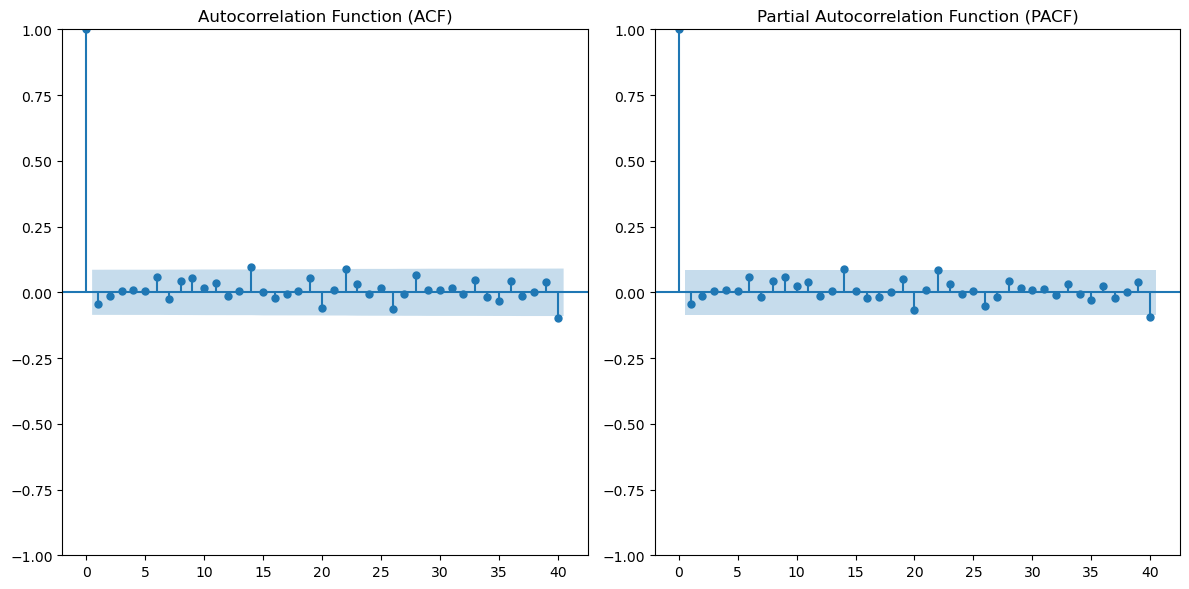

In [48]:

# Generating ACF and PACF plots again
plt.figure(figsize=(12, 6))

plt.subplot(121)
plot_acf(weekly_data['Total'].dropna(), ax=plt.gca(), lags=40)
plt.title('Autocorrelation Function (ACF)')

plt.subplot(122)
plot_pacf(weekly_data['Total'].dropna(), ax=plt.gca(), lags=40, method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

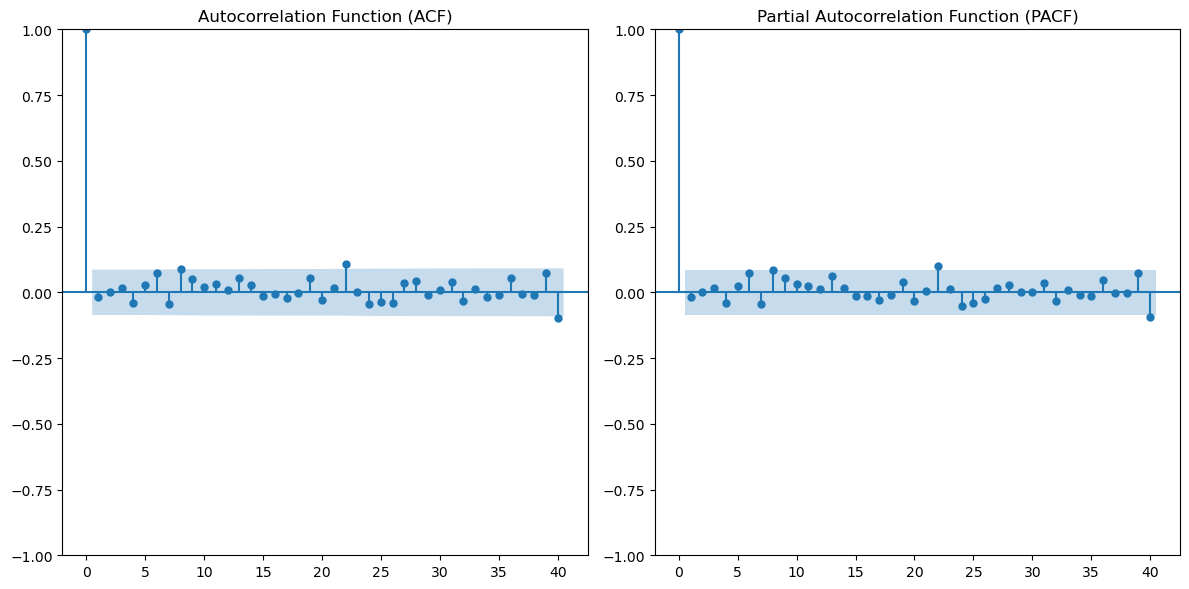

In [49]:

# Generating ACF and PACF plots again
plt.figure(figsize=(12, 6))

plt.subplot(121)
plot_acf(data_without_outliers['Total'].dropna(), ax=plt.gca(), lags=40)
plt.title('Autocorrelation Function (ACF)')

plt.subplot(122)
plot_pacf(data_without_outliers['Total'].dropna(), ax=plt.gca(), lags=40, method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

##### Moving Average and Exponential Smoothing

In [50]:
# Moving Average forecast without outliers
window_size = 4  # Adjust as needed
moving_avg_model_w = train_data_w['Total'].rolling(window=window_size).mean().iloc[-1]
moving_avg_forecast_w = np.repeat(moving_avg_model_w, len(test_data_w))
moving_avg_performance_w = evaluate_forecast(test_data_w['Total'], moving_avg_forecast_w)
print("Moving Average Model Performance:")
print(moving_avg_performance_w)
#plot_forecast(test_data_w['Total'], moving_avg_forecast_w, "Moving Average")

Moving Average Model Performance:
{'Mean Squared Error (MSE)': 3596.653846153846, 'Mean Absolute Error (MAE)': 48.20192307692308, 'Root Mean Squared Error (RMSE)': 59.97210890200416, 'Mean Absolute Scaled Error (MASE)': inf, 'R-squared (R²)': -0.0001332777186804357, 'Accuracy (%)': 98.73931170299409}


In [51]:
# Moving Average forecast with outliers
window_size = 4  # Adjust as needed
moving_avg_model = train_data['Total'].rolling(window=window_size).mean().iloc[-1]
moving_avg_forecast = np.repeat(moving_avg_model, len(test_data))
moving_avg_performance = evaluate_forecast(test_data['Total'], moving_avg_forecast)
print("Moving Average Model Performance:")
print(moving_avg_performance)
#plot_forecast(test_data['Total'], moving_avg_forecast, "Moving Average")

Moving Average Model Performance:
{'Mean Squared Error (MSE)': 5825.792857142857, 'Mean Absolute Error (MAE)': 52.385714285714286, 'Root Mean Squared Error (RMSE)': 76.3268816154758, 'Mean Absolute Scaled Error (MASE)': inf, 'R-squared (R²)': -0.004897657133797084, 'Accuracy (%)': 98.61218558985314}


In [52]:
# Exponential Smoothing forecast with outliers
exp_model = SimpleExpSmoothing(train_data_w['Total']).fit(smoothing_level=0.2)  # Adjust smoothing_level
exp_forecast_w = exp_model.forecast(len(test_data_w))
exp_performance_w = evaluate_forecast(test_data_w['Total'], exp_forecast_w)
print("\nExponential Smoothing Model Performance:")
print(exp_performance_w)
#plot_forecast(test_data_w['Total'], exp_forecast_w, "Exponential Smoothing")


Exponential Smoothing Model Performance:
{'Mean Squared Error (MSE)': 3596.9573027008355, 'Mean Absolute Error (MAE)': 48.19822265537458, 'Root Mean Squared Error (RMSE)': 59.97463882926545, 'Mean Absolute Scaled Error (MASE)': nan, 'R-squared (R²)': 1.0, 'Accuracy (%)': 0}


D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Neha\AppData\Local\Temp\ipykernel_11340\3540671198.py:13: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mase = np.mean(np.abs(actual - predicted) / np.abs(actual - naive_forecast))
C:\Users\Neha\AppData\Local\Temp\ipykernel_11340\3540671198.py:20: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  accuracy = max(0, 100 - (np.mean(np.abs((actual - predicted) / 

In [53]:
# Exponential Smoothing forecast with outliers

exp_model = SimpleExpSmoothing(train_data['Total']).fit(smoothing_level=0.2)  # Adjust smoothing_level
exp_forecast = exp_model.forecast(len(test_data))
exp_performance = evaluate_forecast(test_data['Total'], exp_forecast)
print("\nExponential Smoothing Model Performance:")
print(exp_performance)
#plot_forecast(test_data['Total'], exp_forecast, "Exponential Smoothing")


Exponential Smoothing Model Performance:
{'Mean Squared Error (MSE)': 5827.873796031208, 'Mean Absolute Error (MAE)': 52.38388752273919, 'Root Mean Squared Error (RMSE)': 76.34051215462998, 'Mean Absolute Scaled Error (MASE)': inf, 'R-squared (R²)': -0.005256600656991406, 'Accuracy (%)': 98.61216375156305}


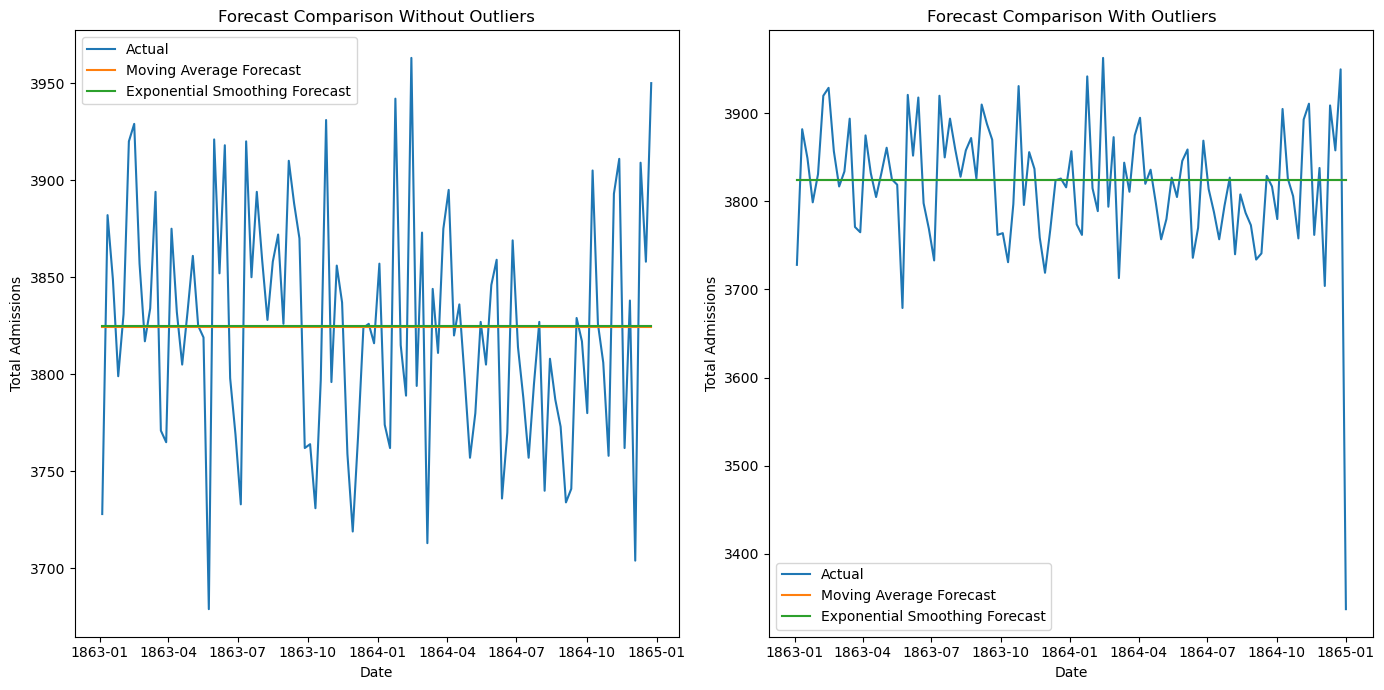

In [54]:
plt.figure(figsize=(14, 7))

# Plot actual vs. forecasted values for the dataset without outliers
plt.subplot(1, 2, 1)
plt.plot(test_data_w.index, test_data_w['Total'], label='Actual')
plt.plot(test_data_w.index, moving_avg_forecast_w, label='Moving Average Forecast')
plt.plot(test_data_w.index, exp_forecast_w, label='Exponential Smoothing Forecast')
plt.title('Forecast Comparison Without Outliers')
plt.xlabel('Date')
plt.ylabel('Total Admissions')
plt.legend()

# Plot actual vs. forecasted values for the dataset with outliers
plt.subplot(1, 2, 2)
plt.plot(test_data.index, test_data['Total'], label='Actual')
plt.plot(test_data.index, moving_avg_forecast, label='Moving Average Forecast')
plt.plot(test_data.index, exp_forecast, label='Exponential Smoothing Forecast')
plt.title('Forecast Comparison With Outliers')
plt.xlabel('Date')
plt.ylabel('Total Admissions')
plt.legend()

plt.tight_layout()
plt.show()

##### ML models

In [57]:

# Train the Random Forest model without outliers
rf_model_w = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_w.fit(train_data_w[['Year','Month','Day']],train_data_w['Total'])

# Perform the prediction
rf_forecast_w = rf_model_w.predict(test_data_w[['Year','Month','Day']])

# Evaluate performance (You will need to define the 'evaluate_forecast' function)
rf_performance_w = evaluate_forecast(test_data_w['Total'], rf_forecast_w)
print("\nRandom Forest Model Performance:")
print(rf_performance_w)

# Plot forecast (You will need to define the 'plot_forecast' function)
#plot_forecast(test_data_w['Total'], rf_forecast, "Random forest")


Random Forest Model Performance:
{'Mean Squared Error (MSE)': 4296.20015, 'Mean Absolute Error (MAE)': 52.545384615384606, 'Root Mean Squared Error (RMSE)': 65.54540525467823, 'Mean Absolute Scaled Error (MASE)': inf, 'R-squared (R²)': -0.194658402378596, 'Accuracy (%)': 98.61947361353504}


In [58]:

# Train the Random Forest model with outliers
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(train_data[['Year','Month','Day']],train_data['Total'])

# Perform the prediction
rf_forecast = rf_model.predict(test_data[['Year','Month','Day']])

# Evaluate performance (You will need to define the 'evaluate_forecast' function)
rf_performance = evaluate_forecast(test_data['Total'], rf_forecast)
print("\nRandom Forest Model Performance:")
print(rf_performance)

# Plot forecast (You will need to define the 'plot_forecast' function)
#plot_forecast(test_data['Log_Total'], rf_forecast, "Random forest")


Random Forest Model Performance:
{'Mean Squared Error (MSE)': 6460.305494285715, 'Mean Absolute Error (MAE)': 58.53095238095238, 'Root Mean Squared Error (RMSE)': 80.37602561887292, 'Mean Absolute Scaled Error (MASE)': inf, 'R-squared (R²)': -0.11434546589082761, 'Accuracy (%)': 98.44829268942297}


In [59]:

# Gradient Boosting Modelwithout outliers
gb_model_w = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model_w.fit(train_data_w[['Year','Month','Day']],train_data_w['Total'])
gb_forecast_w = gb_model_w.predict(test_data_w[['Year','Month','Day']])

# Evaluate performance
gb_performance_w = evaluate_forecast(test_data_w['Total'], gb_forecast_w)
print("\nGradient Boosting Model Performance:")
print(gb_performance_w)
#plot_forecast(test_data['Log_Total'], gb_forecast, "Gradient Boosting")


Gradient Boosting Model Performance:
{'Mean Squared Error (MSE)': 4495.485557000799, 'Mean Absolute Error (MAE)': 53.503484071976814, 'Root Mean Squared Error (RMSE)': 67.0483822101682, 'Mean Absolute Scaled Error (MASE)': inf, 'R-squared (R²)': -0.25007434615042956, 'Accuracy (%)': 98.59427585866135}


In [60]:

# Gradient Boosting Model with outliers
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(train_data[['Year','Month','Day']],train_data['Total'])
gb_forecast = gb_model.predict(test_data[['Year','Month','Day']])

# Evaluate performance
gb_performance = evaluate_forecast(test_data['Total'], gb_forecast)
print("\nGradient Boosting Model Performance:")
print(gb_performance)
#plot_forecast(test_data['Log_Total'], gb_forecast, "Gradient Boosting")


Gradient Boosting Model Performance:
{'Mean Squared Error (MSE)': 6829.512619700758, 'Mean Absolute Error (MAE)': 59.084221958497594, 'Root Mean Squared Error (RMSE)': 82.64086531311708, 'Mean Absolute Scaled Error (MASE)': inf, 'R-squared (R²)': -0.1780304242174504, 'Accuracy (%)': 98.43253479380903}


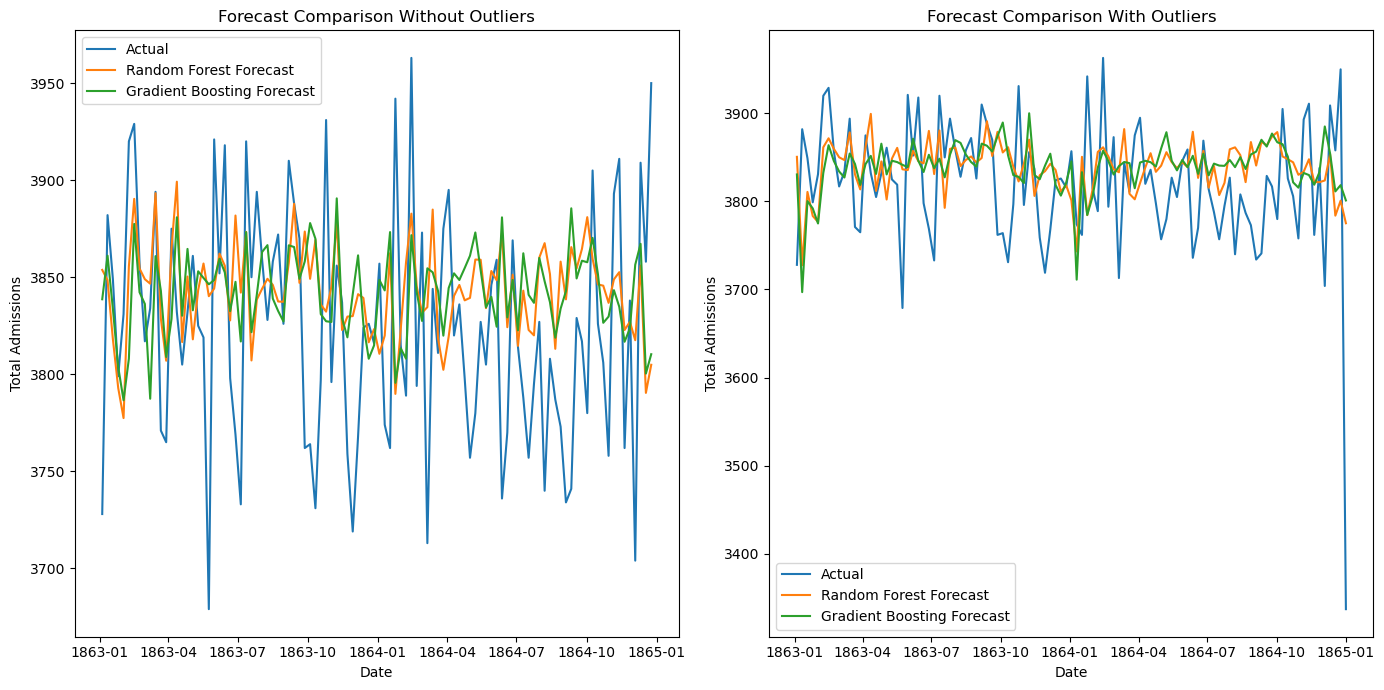

In [61]:
plt.figure(figsize=(14, 7))

# Plot actual vs. forecasted values for the dataset without outliers
plt.subplot(1, 2, 1)
plt.plot(test_data_w.index, test_data_w['Total'], label='Actual')
plt.plot(test_data_w.index, rf_forecast_w, label='Random Forest Forecast')
plt.plot(test_data_w.index, gb_forecast_w, label='Gradient Boosting Forecast')
plt.title('Forecast Comparison Without Outliers')
plt.xlabel('Date')
plt.ylabel('Total Admissions')
plt.legend()

# Plot actual vs. forecasted values for the dataset with outliers
plt.subplot(1, 2, 2)
plt.plot(test_data.index, test_data['Total'], label='Actual')
plt.plot(test_data.index, rf_forecast, label='Random Forest Forecast')
plt.plot(test_data.index, gb_forecast, label='Gradient Boosting Forecast')
plt.title('Forecast Comparison With Outliers')
plt.xlabel('Date')
plt.ylabel('Total Admissions')
plt.legend()

plt.tight_layout()
plt.show()

##### ARIMA and SARIMA

In [65]:
# Fit ARIMA model without outliers
arima_model_w = ARIMA(train_data_w['Total'], order=(1, 0, 1))
arima_model_fit_w = arima_model_w.fit()

# Forecast
arima_predictions_w = arima_model_fit_w.forecast(steps=len(test_data_w))

# Evaluate predictions
print("ARIMA Model Performance:")
arima_performance_w = evaluate_forecast(test_data_w['Total'], arima_predictions_w)
print(arima_performance_w)
#plot_forecast(test_data_w['Total'], arima_predictions_w, "ARIMA")

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA Model Performance:
{'Mean Squared Error (MSE)': 3716.7328795058443, 'Mean Absolute Error (MAE)': 49.41772805688605, 'Root Mean Squared Error (RMSE)': 60.96501356930747, 'Mean Absolute Scaled Error (MASE)': nan, 'R-squared (R²)': 1.0, 'Accuracy (%)': 0}


D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Neha\AppData\Local\Temp\ipykernel_11340\3540671198.py:13: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mase = np.mean(np.abs(actual - predicted) / np.abs(actual - naive_forecast))
C:\Users\Neha\AppData\Local\Temp\ipykernel_11340\3540671198.py:20: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  accuracy = max(0, 100 - (np.mean(np.abs((actual - predicted) / actual)) * 100))


ARIMA Model Performance:
{'Mean Squared Error (MSE)': 6035.793655220061, 'Mean Absolute Error (MAE)': 53.65760440082254, 'Root Mean Squared Error (RMSE)': 77.69037041500098, 'Mean Absolute Scaled Error (MASE)': inf, 'R-squared (R²)': -0.04112093440416409, 'Accuracy (%)': 98.5753130133172}


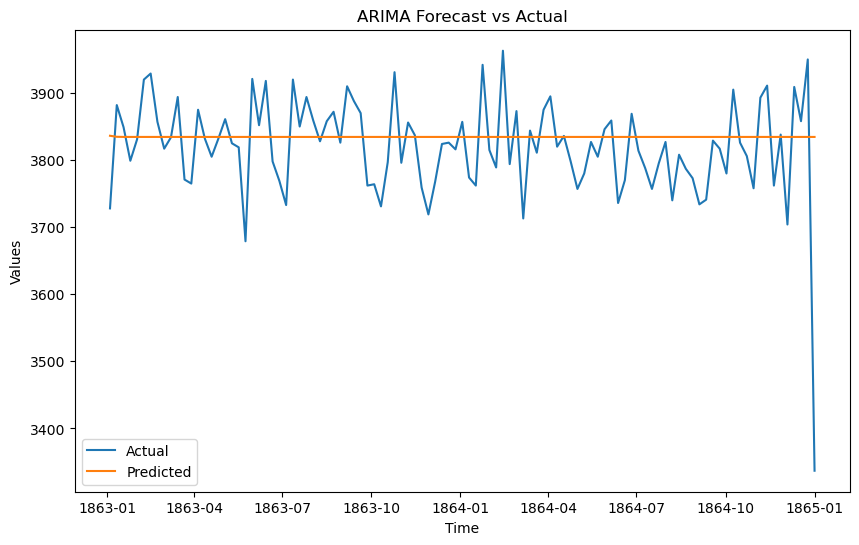

In [67]:
# Fit ARIMA model with outliers
arima_model = ARIMA(train_data['Total'], order=(1, 0, 1))
arima_model_fit = arima_model.fit()

# Forecast
arima_predictions = arima_model_fit.forecast(steps=len(test_data))

# Evaluate predictions
print("ARIMA Model Performance:")
arima_performance = evaluate_forecast(test_data['Total'], arima_predictions)
print(arima_performance)
plot_forecast(test_data['Total'], arima_predictions, "ARIMA")

In [13]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools



# Define the p, d, q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, d, and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, d, q triplets
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

# Initialize a variable to store the best AIC and the best parameters
best_aic = float("inf")
best_pdq = None
best_seasonal_pdq = None

# Grid search to find the best SARIMA model parameters
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(train_data_diff_log,
                            order=param,
                            seasonal_order=param_seasonal,
                            enforce_stationarity=False,
                            enforce_invertibility=False)

            results = model.fit(disp=False)
            
            # Check if the current model's AIC is lower than the best one so far
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            continue

best_aic, best_pdq, best_seasonal_pdq

D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarnin

D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retv

D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retv

D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retv

D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seas

D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarnin

D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarnin

D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seas

D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarnin

D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarnin

D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seas

D:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarnin

(-2258.971967309913, (0, 0, 1), (0, 0, 0, 52))

In [73]:

# Fit SARIMA model without outliers
sarima_model_w = SARIMAX(train_data_w['Total'], order=(1, 1, 0), seasonal_order=(1, 1, 1, 52))
sarima_model_fit_w = sarima_model_w.fit()

# Forecast
sarima_predictions_w = sarima_model_fit_w.forecast(steps=len(test_data_w))

# Evaluate predictions
print("SARIMA Model Performance:")
sarima_performance_w = evaluate_forecast(test_data_w['Total'], sarima_predictions_w)
print(sarima_performance_w)
#plot_forecast(test_data_w['Total'], sarima_predictions_w, "SARIMA")

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA Model Performance:
{'Mean Squared Error (MSE)': 4283.096631002687, 'Mean Absolute Error (MAE)': 52.88654241143584, 'Root Mean Squared Error (RMSE)': 65.44537134895552, 'Mean Absolute Scaled Error (MASE)': nan, 'R-squared (R²)': 1.0, 'Accuracy (%)': 0}


D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Neha\AppData\Local\Temp\ipykernel_11340\3540671198.py:13: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mase = np.mean(np.abs(actual - predicted) / np.abs(actual - naive_forecast))
C:\Users\Neha\AppData\Local\Temp\ipykernel_11340\3540671198.py:20: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  accuracy = max(0, 100 - (np.mean(np.abs((actual - predicted) / actual)) * 100))


In [71]:

# Fit SARIMA model with outliers
sarima_model = SARIMAX(train_data['Total'], order=(1, 1, 0), seasonal_order=(1, 1, 1, 52))
sarima_model_fit = sarima_model.fit()

# Forecast
sarima_predictions = sarima_model_fit.forecast(steps=len(test_data))

# Evaluate predictions
print("SARIMA Model Performance:")
sarima_performance = evaluate_forecast(test_data['Total'], sarima_predictions)
print(sarima_performance)
#plot_forecast(test_data['Total'], sarima_predictions, "SARIMA")

SARIMA Model Performance:
{'Mean Squared Error (MSE)': 5908.572337681097, 'Mean Absolute Error (MAE)': 56.07370373378205, 'Root Mean Squared Error (RMSE)': 76.86723838984393, 'Mean Absolute Scaled Error (MASE)': inf, 'R-squared (R²)': -0.01917638418287848, 'Accuracy (%)': 98.52206542569117}


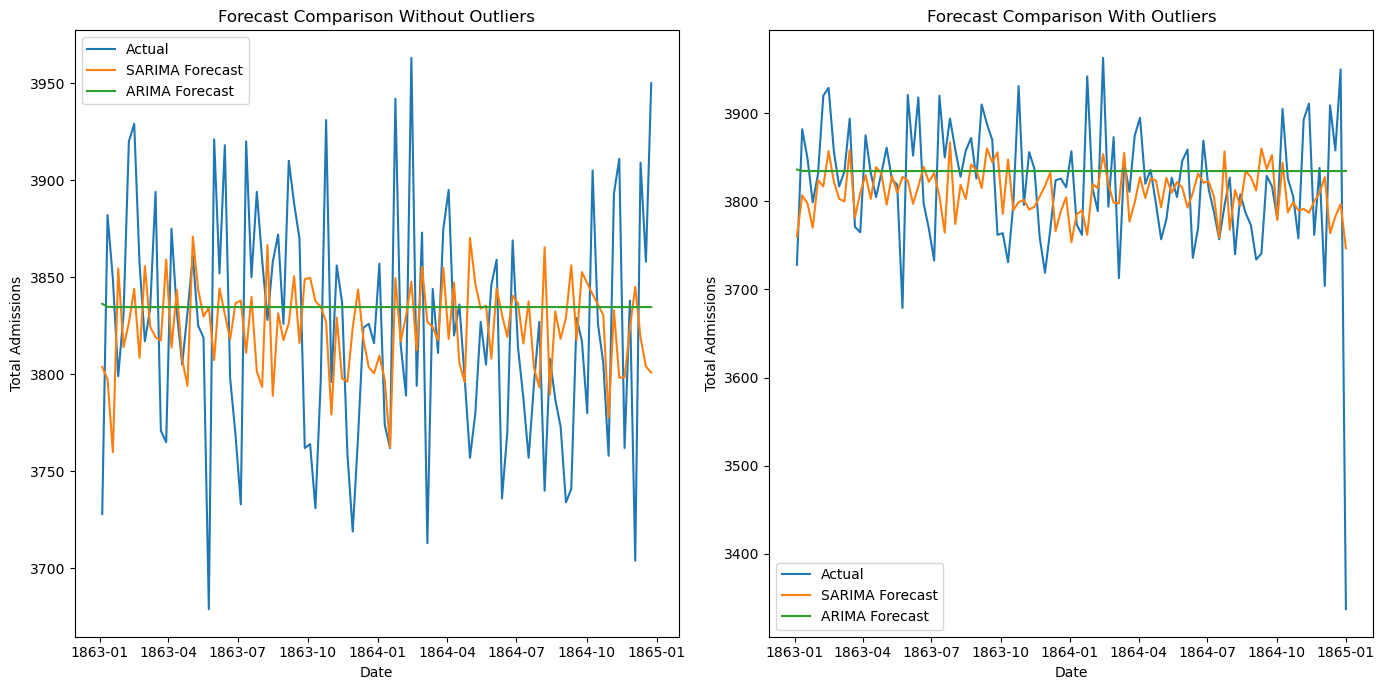

In [74]:
plt.figure(figsize=(14, 7))

# Plot actual vs. forecasted values for the dataset without outliers
plt.subplot(1, 2, 1)
plt.plot(test_data_w.index, test_data_w['Total'], label='Actual')
plt.plot(test_data_w.index, sarima_predictions_w, label='SARIMA Forecast')
plt.plot(test_data_w.index, arima_predictions_w, label='ARIMA Forecast')
plt.title('Forecast Comparison Without Outliers')
plt.xlabel('Date')
plt.ylabel('Total Admissions')
plt.legend()

# Plot actual vs. forecasted values for the dataset with outliers
plt.subplot(1, 2, 2)
plt.plot(test_data.index, test_data['Total'], label='Actual')
plt.plot(test_data.index, sarima_predictions, label='SARIMA Forecast')
plt.plot(test_data.index, arima_predictions, label='ARIMA Forecast')
plt.title('Forecast Comparison With Outliers')
plt.xlabel('Date')
plt.ylabel('Total Admissions')
plt.legend()

plt.tight_layout()
plt.show()

##### LSTM and RNN

In [75]:
#preparation of dataset for lstm and rnn

#without outliers dataset:


# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_without_outliers[['Total', 'Year', 'Month', 'Day']])

# Separate into input features (X) and output target (y)
X_w = scaled_data[:, 1:]  # 'Year', 'Month', 'Day' as features
y_w = scaled_data[:, 0]   # 'Total' as the target

# Reshape input to be 3D [samples, time steps, features] for LSTM
X_w = X_w.reshape((X_w.shape[0], 1, X_w.shape[1]))

# Splitting the data into training and testing sets
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_w, y_w, test_size=0.2, random_state=42)


In [76]:
#with outliers dataset:

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(weekly_data[['Total', 'Year', 'Month', 'Day']])

# Separate into input features (X) and output target (y)
X = scaled_data[:, 1:]  # 'Year', 'Month', 'Day' as features
y = scaled_data[:, 0]   # 'Total' as the target

# Reshape input to be 3D [samples, time steps, features] for LSTM
X = X.reshape((X.shape[0], 1, X.shape[1]))

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Epoch 1/100
13/13 - 3s - loss: 0.2629 - val_loss: 0.2142 - 3s/epoch - 264ms/step
Epoch 2/100
13/13 - 0s - loss: 0.1803 - val_loss: 0.1319 - 54ms/epoch - 4ms/step
Epoch 3/100
13/13 - 0s - loss: 0.0977 - val_loss: 0.0651 - 50ms/epoch - 4ms/step
Epoch 4/100
13/13 - 0s - loss: 0.0527 - val_loss: 0.0618 - 44ms/epoch - 3ms/step
Epoch 5/100
13/13 - 0s - loss: 0.0498 - val_loss: 0.0559 - 44ms/epoch - 3ms/step
Epoch 6/100
13/13 - 0s - loss: 0.0467 - val_loss: 0.0532 - 43ms/epoch - 3ms/step
Epoch 7/100
13/13 - 0s - loss: 0.0457 - val_loss: 0.0521 - 46ms/epoch - 4ms/step
Epoch 8/100
13/13 - 0s - loss: 0.0447 - val_loss: 0.0510 - 50ms/epoch - 4ms/step
Epoch 9/100
13/13 - 0s - loss: 0.0439 - val_loss: 0.0496 - 57ms/epoch - 4ms/step
Epoch 10/100
13/13 - 0s - loss: 0.0432 - val_loss: 0.0486 - 53ms/epoch - 4ms/step
Epoch 11/100
13/13 - 0s - loss: 0.0426 - val_loss: 0.0479 - 50ms/epoch - 4ms/step
Epoch 12/100
13/13 - 0s - loss: 0.0420 - val_loss: 0.0470 - 52ms/epoch - 4ms/step
Epoch 13/100
13/13 - 0s -

4/4 [==============================] - 0s 2ms/step
LSTM Model Evaluation: {'Mean Squared Error (MSE)': 0.03919721914064957, 'Mean Absolute Error (MAE)': 0.1594248241644639, 'Root Mean Squared Error (RMSE)': 0.19798287587730806, 'Mean Absolute Scaled Error (MASE)': inf, 'R-squared (R²)': -103.64074221188548, 'Accuracy (%)': 45.86562025161622}


C:\Users\Neha\AppData\Local\Temp\ipykernel_11340\3540671198.py:13: RuntimeWarning: divide by zero encountered in divide
  mase = np.mean(np.abs(actual - predicted) / np.abs(actual - naive_forecast))


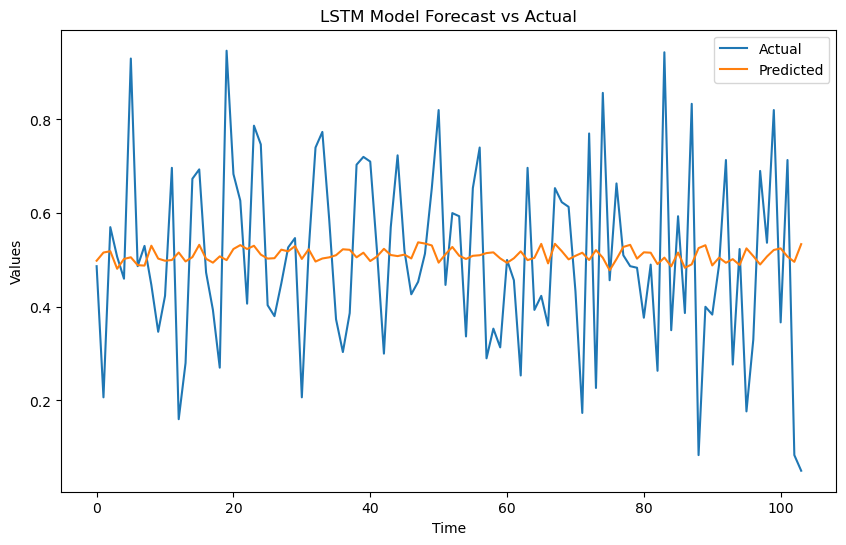

In [77]:
# Define the LSTM model architecture without outliers
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train_w.shape[1], X_train_w.shape[2])))
model.add(LSTM(50))
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model
history = model.fit(X_train_w, y_train_w, epochs=100, batch_size=32, validation_data=(X_test_w, y_test_w), verbose=2)

# Making predictions
lstm_predictions_w = model.predict(X_test_w)

# Evaluate
lstm_eval_w = evaluate_forecast(y_test_w, lstm_predictions_w)

print("LSTM Model Evaluation:", lstm_eval_w)
#print("RNN Model Evaluation:", rnn_eval)
# Plot
plot_forecast(y_test_w, lstm_predictions_w,'LSTM Model')

Epoch 1/100
14/14 - 3s - loss: 0.4978 - val_loss: 0.4184 - 3s/epoch - 221ms/step
Epoch 2/100
14/14 - 0s - loss: 0.3564 - val_loss: 0.2585 - 50ms/epoch - 4ms/step
Epoch 3/100
14/14 - 0s - loss: 0.1806 - val_loss: 0.0768 - 47ms/epoch - 3ms/step
Epoch 4/100
14/14 - 0s - loss: 0.0355 - val_loss: 0.0195 - 58ms/epoch - 4ms/step
Epoch 5/100
14/14 - 0s - loss: 0.0191 - val_loss: 0.0174 - 47ms/epoch - 3ms/step
Epoch 6/100
14/14 - 0s - loss: 0.0129 - val_loss: 0.0142 - 56ms/epoch - 4ms/step
Epoch 7/100
14/14 - 0s - loss: 0.0119 - val_loss: 0.0137 - 58ms/epoch - 4ms/step
Epoch 8/100
14/14 - 0s - loss: 0.0115 - val_loss: 0.0135 - 50ms/epoch - 4ms/step
Epoch 9/100
14/14 - 0s - loss: 0.0109 - val_loss: 0.0125 - 48ms/epoch - 3ms/step
Epoch 10/100
14/14 - 0s - loss: 0.0104 - val_loss: 0.0122 - 48ms/epoch - 3ms/step
Epoch 11/100
14/14 - 0s - loss: 0.0099 - val_loss: 0.0120 - 52ms/epoch - 4ms/step
Epoch 12/100
14/14 - 0s - loss: 0.0096 - val_loss: 0.0115 - 55ms/epoch - 4ms/step
Epoch 13/100
14/14 - 0s -

4/4 [==============================] - 0s 1ms/step
LSTM Model Evaluation: {'Mean Squared Error (MSE)': 0.009862984482796112, 'Mean Absolute Error (MAE)': 0.07559520517582866, 'Root Mean Squared Error (RMSE)': 0.09931255954206453, 'Mean Absolute Scaled Error (MASE)': inf, 'R-squared (R²)': -113.76956313690937, 'Accuracy (%)': 0}


C:\Users\Neha\AppData\Local\Temp\ipykernel_11340\3540671198.py:13: RuntimeWarning: divide by zero encountered in divide
  mase = np.mean(np.abs(actual - predicted) / np.abs(actual - naive_forecast))
C:\Users\Neha\AppData\Local\Temp\ipykernel_11340\3540671198.py:20: RuntimeWarning: divide by zero encountered in divide
  accuracy = max(0, 100 - (np.mean(np.abs((actual - predicted) / actual)) * 100))


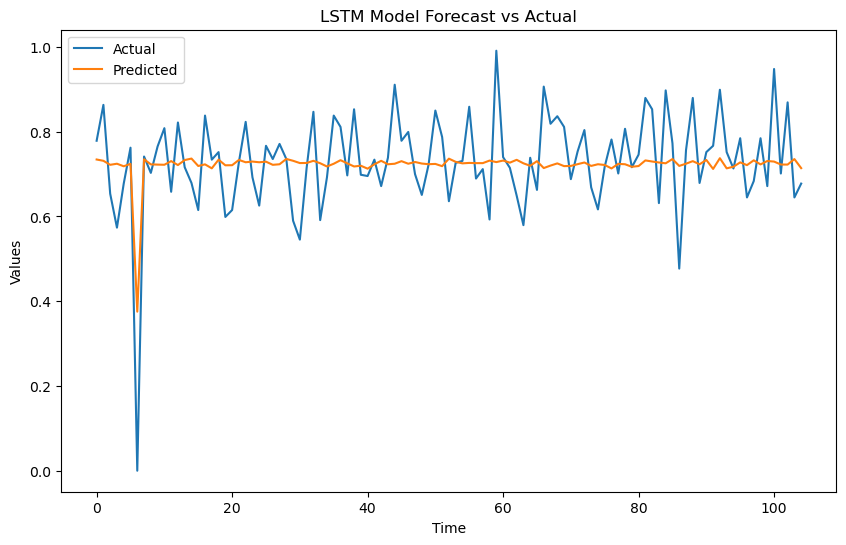

In [78]:

# Define the LSTM model with outliers
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=2)

# Making predictions
lstm_predictions = model.predict(X_test)

# Evaluate
lstm_eval = evaluate_forecast(y_test, lstm_predictions)

print("LSTM Model Evaluation:", lstm_eval)
#print("RNN Model Evaluation:", rnn_eval)

# Plot
plot_forecast(y_test, lstm_predictions,'LSTM Model')

Epoch 1/100
13/13 - 1s - loss: 0.0952 - val_loss: 0.0799 - 1s/epoch - 98ms/step
Epoch 2/100
13/13 - 0s - loss: 0.0559 - val_loss: 0.0589 - 40ms/epoch - 3ms/step
Epoch 3/100
13/13 - 0s - loss: 0.0503 - val_loss: 0.0553 - 41ms/epoch - 3ms/step
Epoch 4/100
13/13 - 0s - loss: 0.0471 - val_loss: 0.0508 - 70ms/epoch - 5ms/step
Epoch 5/100
13/13 - 0s - loss: 0.0442 - val_loss: 0.0473 - 47ms/epoch - 4ms/step
Epoch 6/100
13/13 - 0s - loss: 0.0416 - val_loss: 0.0451 - 45ms/epoch - 3ms/step
Epoch 7/100
13/13 - 0s - loss: 0.0405 - val_loss: 0.0423 - 42ms/epoch - 3ms/step
Epoch 8/100
13/13 - 0s - loss: 0.0387 - val_loss: 0.0425 - 40ms/epoch - 3ms/step
Epoch 9/100
13/13 - 0s - loss: 0.0389 - val_loss: 0.0410 - 39ms/epoch - 3ms/step
Epoch 10/100
13/13 - 0s - loss: 0.0383 - val_loss: 0.0402 - 39ms/epoch - 3ms/step
Epoch 11/100
13/13 - 0s - loss: 0.0375 - val_loss: 0.0388 - 40ms/epoch - 3ms/step
Epoch 12/100
13/13 - 0s - loss: 0.0374 - val_loss: 0.0416 - 38ms/epoch - 3ms/step
Epoch 13/100
13/13 - 0s - 

4/4 [==============================] - 0s 996us/step
RNN Model Evaluation:
{'Mean Squared Error (MSE)': 0.03991974373518495, 'Mean Absolute Error (MAE)': 0.15894444397626784, 'Root Mean Squared Error (RMSE)': 0.19979925859518335, 'Mean Absolute Scaled Error (MASE)': inf, 'R-squared (R²)': -105.22758732871166, 'Accuracy (%)': 48.50756757717348}


C:\Users\Neha\AppData\Local\Temp\ipykernel_11340\3540671198.py:13: RuntimeWarning: divide by zero encountered in divide
  mase = np.mean(np.abs(actual - predicted) / np.abs(actual - naive_forecast))


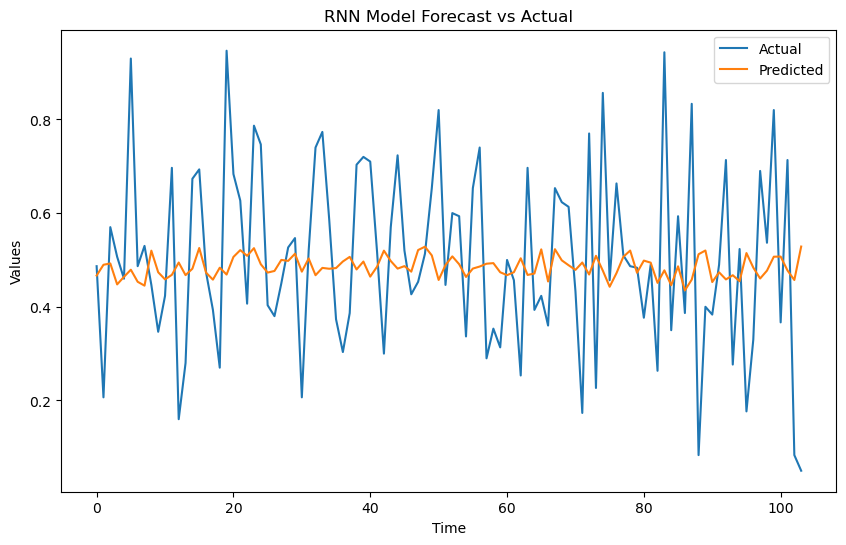

In [79]:
#Rnn without outliers
from tensorflow.keras.layers import SimpleRNN, Dense

# Define the RNN model
model = Sequential()
model.add(SimpleRNN(50, return_sequences=True, input_shape=(X_train_w.shape[1], X_train_w.shape[2])))
model.add(SimpleRNN(50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train_w, y_train_w, epochs=100, batch_size=32, validation_data=(X_test_w, y_test_w), verbose=2)

# Making predictions
rnn_predictions_w = model.predict(X_test_w)

# Evaluate the model
# Evaluate
rnn_eval_w = evaluate_forecast(y_test_w, rnn_predictions_w)

print("RNN Model Evaluation:") 
print(rnn_eval_w)
#print("RNN Model Evaluation:", rnn_eval)

# Plot
plot_forecast(y_test_w, rnn_predictions_w,'RNN Model')



Epoch 1/100
14/14 - 1s - loss: 0.3607 - val_loss: 0.0557 - 1s/epoch - 94ms/step
Epoch 2/100
14/14 - 0s - loss: 0.0717 - val_loss: 0.0129 - 40ms/epoch - 3ms/step
Epoch 3/100
14/14 - 0s - loss: 0.0163 - val_loss: 0.0179 - 42ms/epoch - 3ms/step
Epoch 4/100
14/14 - 0s - loss: 0.0107 - val_loss: 0.0111 - 41ms/epoch - 3ms/step
Epoch 5/100
14/14 - 0s - loss: 0.0089 - val_loss: 0.0093 - 40ms/epoch - 3ms/step
Epoch 6/100
14/14 - 0s - loss: 0.0080 - val_loss: 0.0088 - 40ms/epoch - 3ms/step
Epoch 7/100
14/14 - 0s - loss: 0.0078 - val_loss: 0.0088 - 40ms/epoch - 3ms/step
Epoch 8/100
14/14 - 0s - loss: 0.0078 - val_loss: 0.0088 - 42ms/epoch - 3ms/step
Epoch 9/100
14/14 - 0s - loss: 0.0079 - val_loss: 0.0089 - 42ms/epoch - 3ms/step
Epoch 10/100
14/14 - 0s - loss: 0.0081 - val_loss: 0.0090 - 41ms/epoch - 3ms/step
Epoch 11/100
14/14 - 0s - loss: 0.0081 - val_loss: 0.0087 - 40ms/epoch - 3ms/step
Epoch 12/100
14/14 - 0s - loss: 0.0081 - val_loss: 0.0089 - 44ms/epoch - 3ms/step
Epoch 13/100
14/14 - 0s - 

4/4 [==============================] - 0s 1ms/step
RNN Model Evaluation:
{'Mean Squared Error (MSE)': 0.009186251583399332, 'Mean Absolute Error (MAE)': 0.07493785809687832, 'Root Mean Squared Error (RMSE)': 0.09584493509518034, 'Mean Absolute Scaled Error (MASE)': inf, 'R-squared (R²)': -125.5536804073865, 'Accuracy (%)': 0}


C:\Users\Neha\AppData\Local\Temp\ipykernel_11340\3540671198.py:13: RuntimeWarning: divide by zero encountered in divide
  mase = np.mean(np.abs(actual - predicted) / np.abs(actual - naive_forecast))
C:\Users\Neha\AppData\Local\Temp\ipykernel_11340\3540671198.py:20: RuntimeWarning: divide by zero encountered in divide
  accuracy = max(0, 100 - (np.mean(np.abs((actual - predicted) / actual)) * 100))


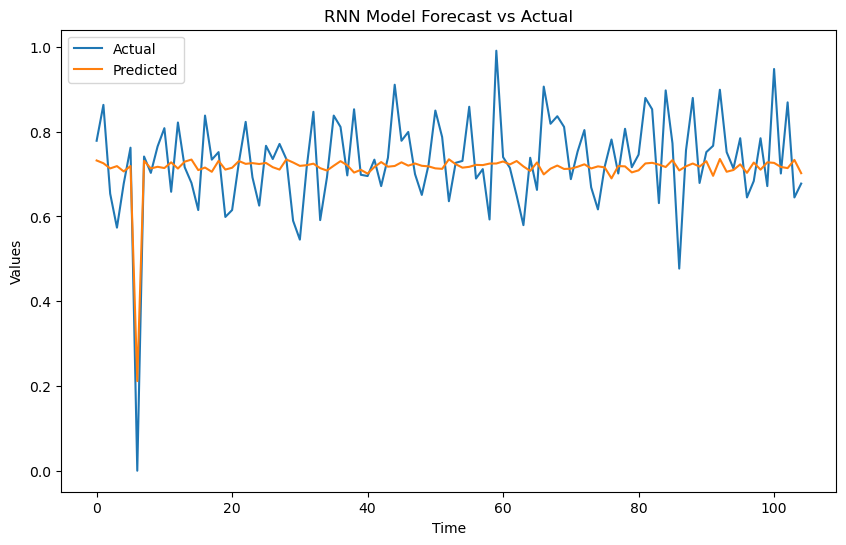

In [80]:
#RNN with outliers
from tensorflow.keras.layers import SimpleRNN, Dense

# Define the RNN model
model = Sequential()
model.add(SimpleRNN(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(SimpleRNN(50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=2)

# Making predictions
rnn_predictions = model.predict(X_test)

# Evaluate the model
# Evaluate
rnn_eval = evaluate_forecast(y_test, rnn_predictions)

print("RNN Model Evaluation:") 
print(rnn_eval)
#print("RNN Model Evaluation:", rnn_eval)

# Plot
plot_forecast(y_test, rnn_predictions,'RNN Model')


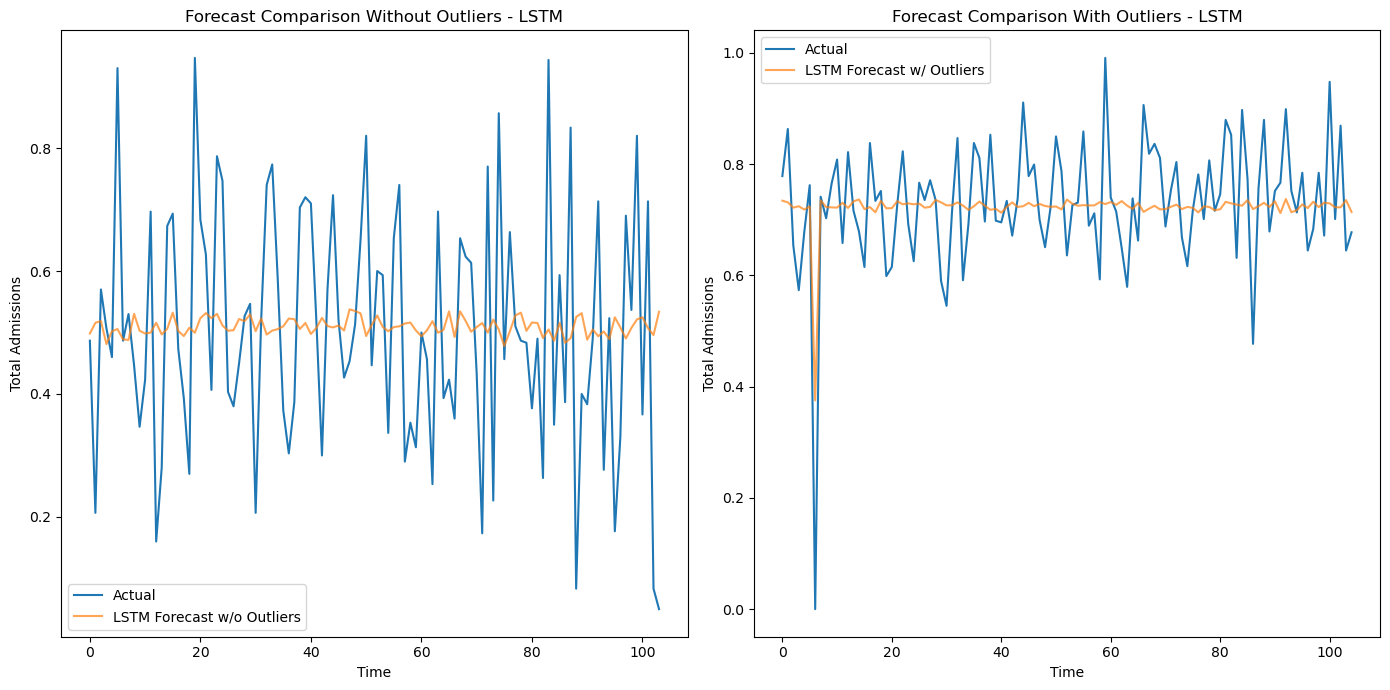

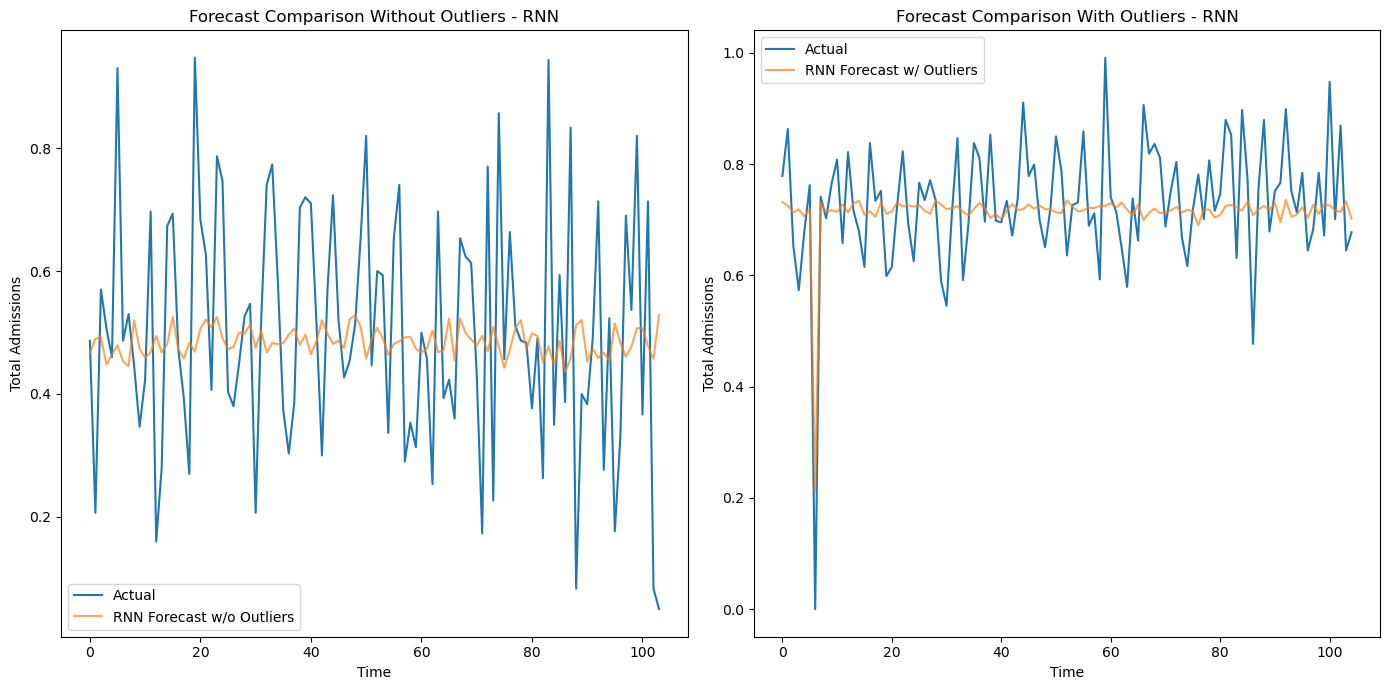

In [81]:

def plot_combined_forecast(actual_w, forecast_w, label_w, actual, forecast, label, title_w, title):
    plt.figure(figsize=(14, 7))

    # Plot for dataset without outliers
    plt.subplot(1, 2, 1)
    plt.plot(actual_w, label='Actual')
    plt.plot(forecast_w, label=label_w, alpha=0.7)
    plt.title(title_w)
    plt.xlabel('Time')
    plt.ylabel('Total Admissions')
    plt.legend()

    # Plot for dataset with outliers
    plt.subplot(1, 2, 2)
    plt.plot(actual, label='Actual')
    plt.plot(forecast, label=label, alpha=0.7)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Total Admissions')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Usage of the function
plot_combined_forecast(
    y_test_w, lstm_predictions_w, 'LSTM Forecast w/o Outliers',
    y_test, lstm_predictions, 'LSTM Forecast w/ Outliers',
    'Forecast Comparison Without Outliers - LSTM', 
    'Forecast Comparison With Outliers - LSTM'
)

plot_combined_forecast(
    y_test_w, rnn_predictions_w, 'RNN Forecast w/o Outliers',
    y_test, rnn_predictions, 'RNN Forecast w/ Outliers',
    'Forecast Comparison Without Outliers - RNN', 
    'Forecast Comparison With Outliers - RNN'
)


##### Facebook Prophet

In [96]:

# Preparing data for Prophet without outliers
# Splitting the data into training and test sets
split_index = int(len(data_without_outliers) * 0.8)
train_data_w = weekly_data.iloc[:split_index]
test_data_w = weekly_data.iloc[split_index:]

# Reset the index and prepare data for Prophet
prophet_train_data_w = train_data_w.reset_index().rename(columns={'ADMIT_DTTM': 'ds', 'Total': 'y'})
prophet_test_data_w = test_data_w.reset_index().rename(columns={'ADMIT_DTTM': 'ds'})

# Initialize and fit the Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_train_data_w[['ds', 'y']])

# Create a date range from the start to the end of the test data, with weekly frequency
custom_future_dates = pd.date_range(start='1862-11-30', end='1865-01-01', freq='W').to_frame(index=False, name='ds')

# Use this custom_future_dates for predictions with Prophet
forecast_w = prophet_model.predict(custom_future_dates)


# Predict on these future dates
#forecast = prophet_model.predict(corrected_future_dates)

# Extract the forecast for the test data period
prophet_predictions_w = forecast_w[-len(prophet_test_data_w):]['yhat']

# Calculate mean squared error
prophet_mse = mean_squared_error(test_data_w['Total'], prophet_predictions_w)
prophet_mse

prophet_performance_w = evaluate_forecast(test_data_w['Total'], prophet_predictions_w)

prophet_mse = mean_squared_error(test_data_w['Total'], prophet_predictions_w)
print('Prophet Model', prophet_performance_w)

# Plot the forecast
plot_plotly(prophet_model, forecast_w)

# Plot components of the forecast
plot_components_plotly(prophet_model, forecast_w)

00:04:51 - cmdstanpy - INFO - Chain [1] start processing
00:04:51 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Neha\AppData\Local\Temp\ipykernel_11340\3540671198.py:13: RuntimeWarning:

'<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.

C:\Users\Neha\AppData\Local\Temp\ipykernel_11340\3540671198.py:20: RuntimeWarning:

'<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.



Prophet Model {'Mean Squared Error (MSE)': 6755.533319922692, 'Mean Absolute Error (MAE)': 59.0202451871655, 'Root Mean Squared Error (RMSE)': 82.1920514400431, 'Mean Absolute Scaled Error (MASE)': nan, 'R-squared (R²)': 1.0, 'Accuracy (%)': 0}


In [83]:
# Preparing data for Prophet with outliers
# Splitting the data into training and test sets
split_index = int(len(weekly_data) * 0.8)
train_data = weekly_data.iloc[:split_index]
test_data = weekly_data.iloc[split_index:]

# Reset the index and prepare data for Prophet
prophet_train_data = train_data.reset_index().rename(columns={'ADMIT_DTTM': 'ds', 'Total': 'y'})
prophet_test_data = test_data.reset_index().rename(columns={'ADMIT_DTTM': 'ds'})

# Initialize and fit the Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_train_data[['ds', 'y']])

# Create a date range from the start to the end of the test data, with weekly frequency
custom_future_dates = pd.date_range(start='1863-01-04', end='1865-01-01', freq='W').to_frame(index=False, name='ds')

# Use this custom_future_dates for predictions with Prophet
forecast = prophet_model.predict(custom_future_dates)


# Predict on these future dates
# Extract the forecast for the test data period
prophet_predictions = forecast[-len(prophet_test_data):]['yhat']

# Calculate mean squared error
prophet_mse = mean_squared_error(test_data['Total'], prophet_predictions)
prophet_mse

prophet_performance = evaluate_forecast(test_data['Total'], prophet_predictions)

prophet_mse = mean_squared_error(test_data['Total'], prophet_predictions)
print('Prophet Model', prophet_performance)

# Plot the forecast
plot_plotly(prophet_model, forecast)

# Plot components of the forecast
plot_components_plotly(prophet_model, forecast)

17:08:11 - cmdstanpy - INFO - Chain [1] start processing
17:08:12 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Neha\AppData\Local\Temp\ipykernel_11340\3540671198.py:13: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mase = np.mean(np.abs(actual - predicted) / np.abs(actual - naive_forecast))
C:\Users\Neha\AppData\Local\Temp\ipykernel_11340\3540671198.py:20: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  accuracy = max(0, 100 - (np.mean(np.abs((actual - predicted) / actual)) * 100))


Prophet Model {'Mean Squared Error (MSE)': 6962.357659333811, 'Mean Absolute Error (MAE)': 60.47957200889503, 'Root Mean Squared Error (RMSE)': 83.44074340113355, 'Mean Absolute Scaled Error (MASE)': nan, 'R-squared (R²)': 1.0, 'Accuracy (%)': 0}


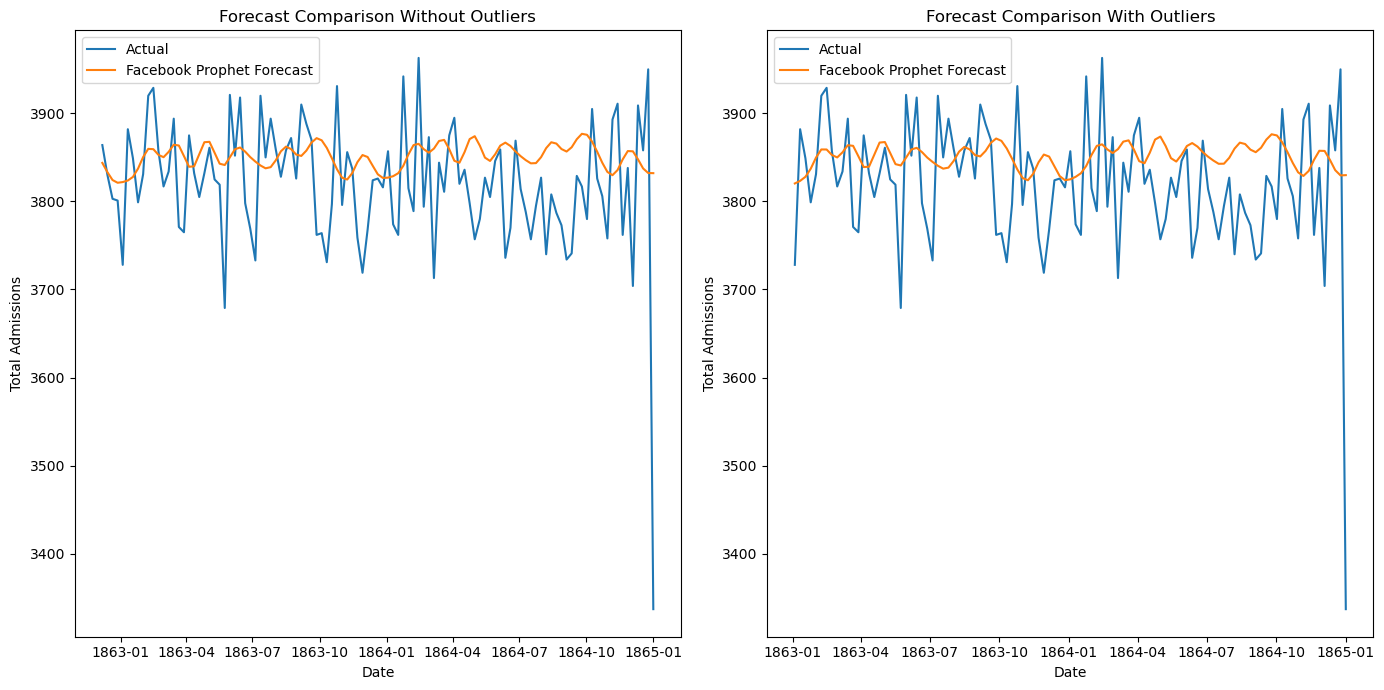

In [91]:
plt.figure(figsize=(14, 7))

# Plot actual vs. forecasted values for the dataset without outliers
plt.subplot(1, 2, 1)
plt.plot(test_data_w.index, test_data_w['Total'], label='Actual')
plt.plot(test_data_w.index, forecast_w['yhat'], label='Facebook Prophet Forecast')
plt.title('Forecast Comparison Without Outliers')
plt.xlabel('Date')
plt.ylabel('Total Admissions')
plt.legend()

# Plot actual vs. forecasted values for the dataset with outliers
plt.subplot(1, 2, 2)
plt.plot(test_data.index, test_data['Total'], label='Actual')
plt.plot(test_data.index, forecast['yhat'], label='Facebook Prophet Forecast')
plt.title('Forecast Comparison With Outliers')
plt.xlabel('Date')
plt.ylabel('Total Admissions')
plt.legend()

plt.tight_layout()
plt.show()

##### Residual plot

In [92]:
#adjustments for residual plots
flattened_lstm_predictions = lstm_predictions.flatten()
flattened_rnn_predictions = rnn_predictions.flatten()
test_data_reset = test_data.reset_index()

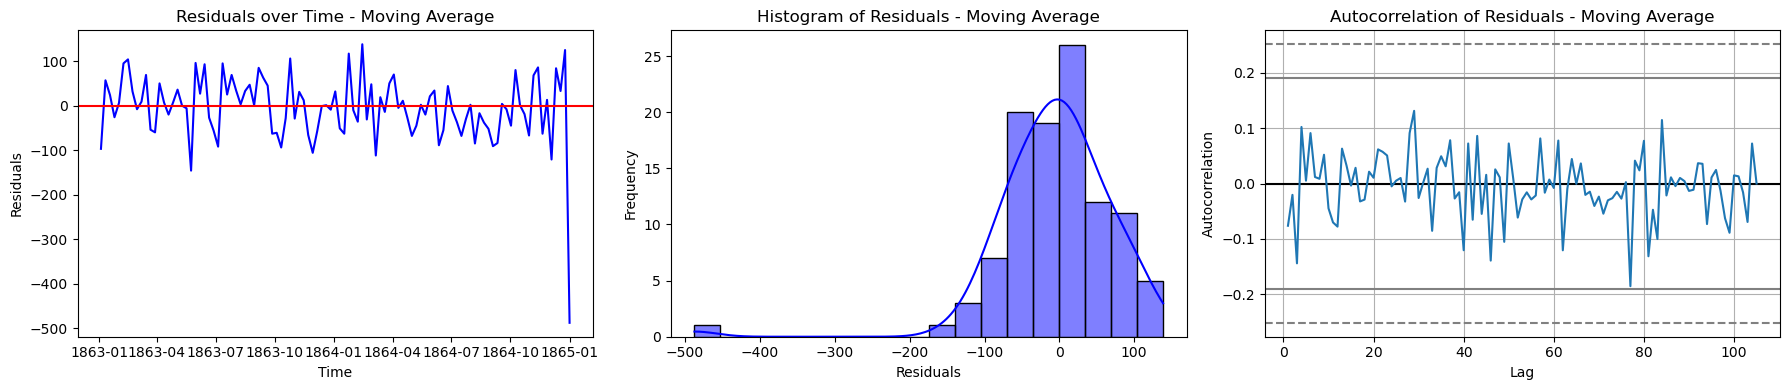

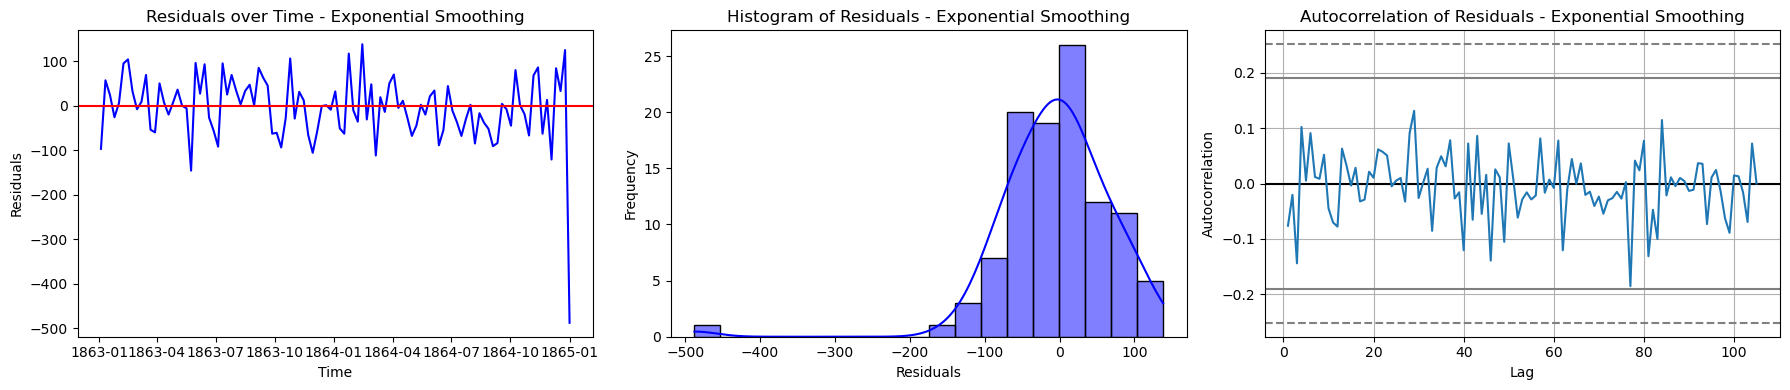

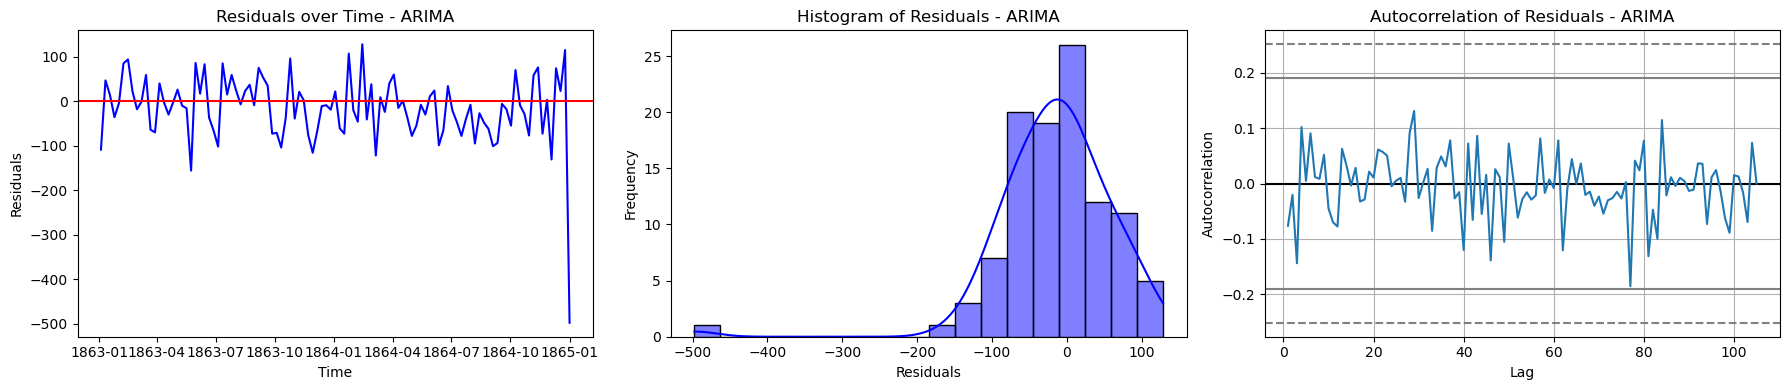

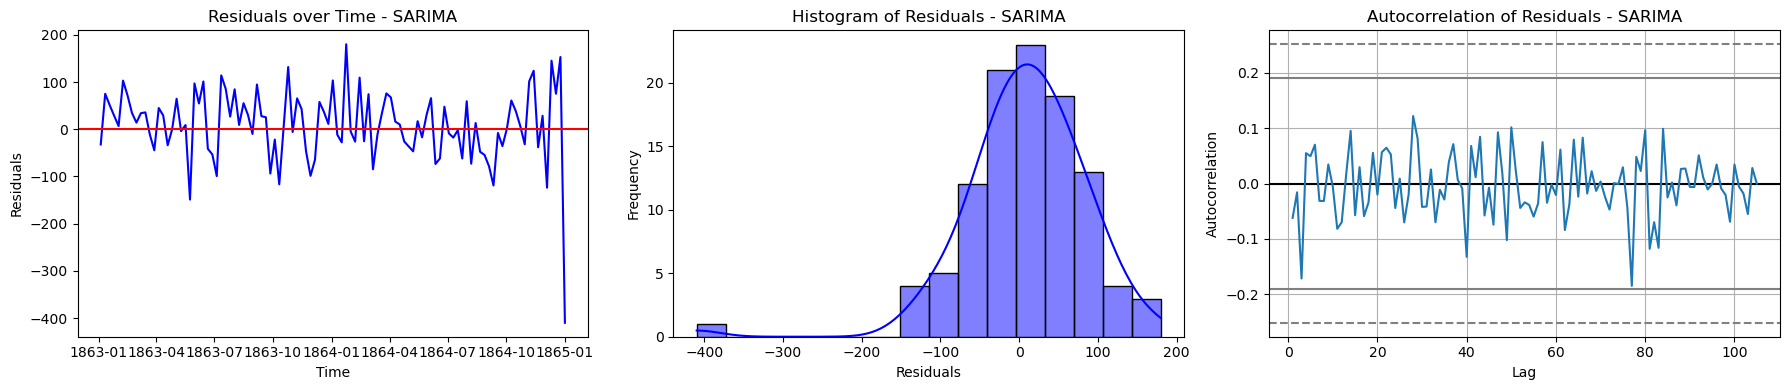

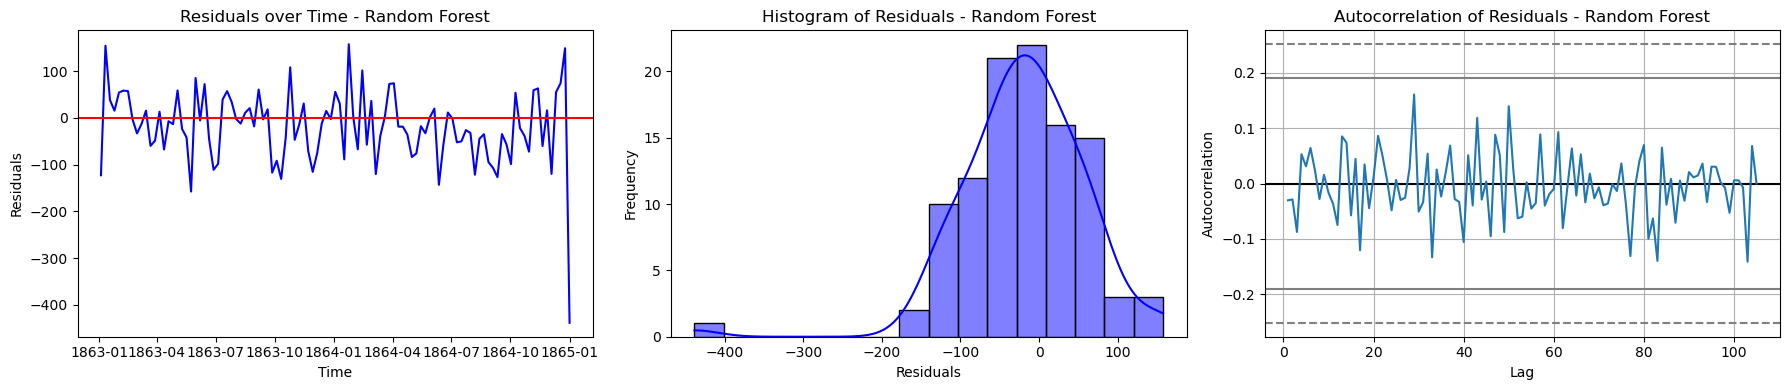

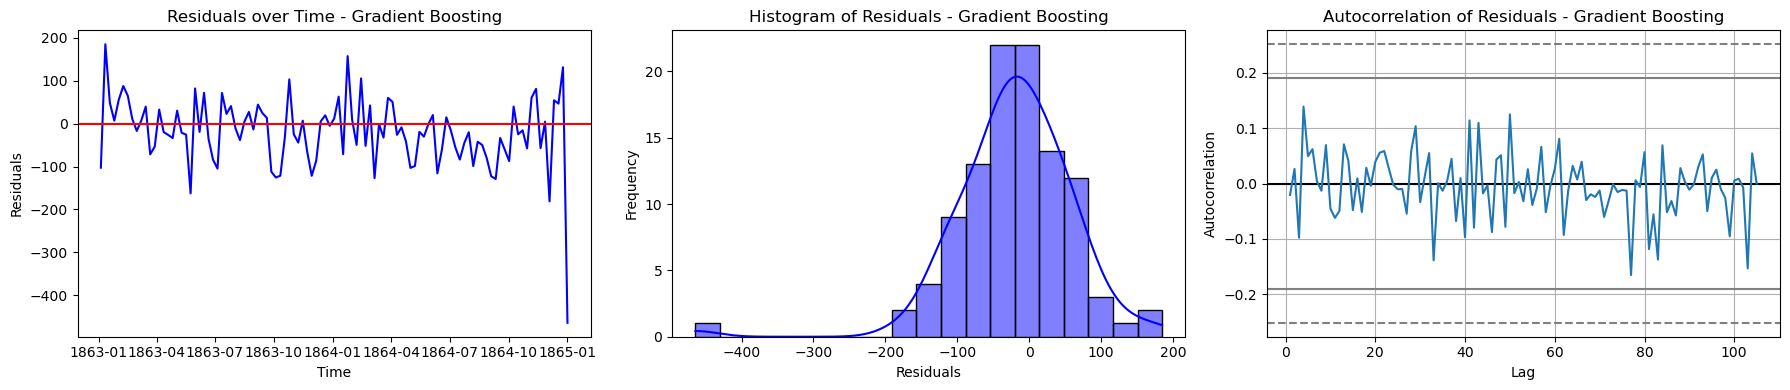

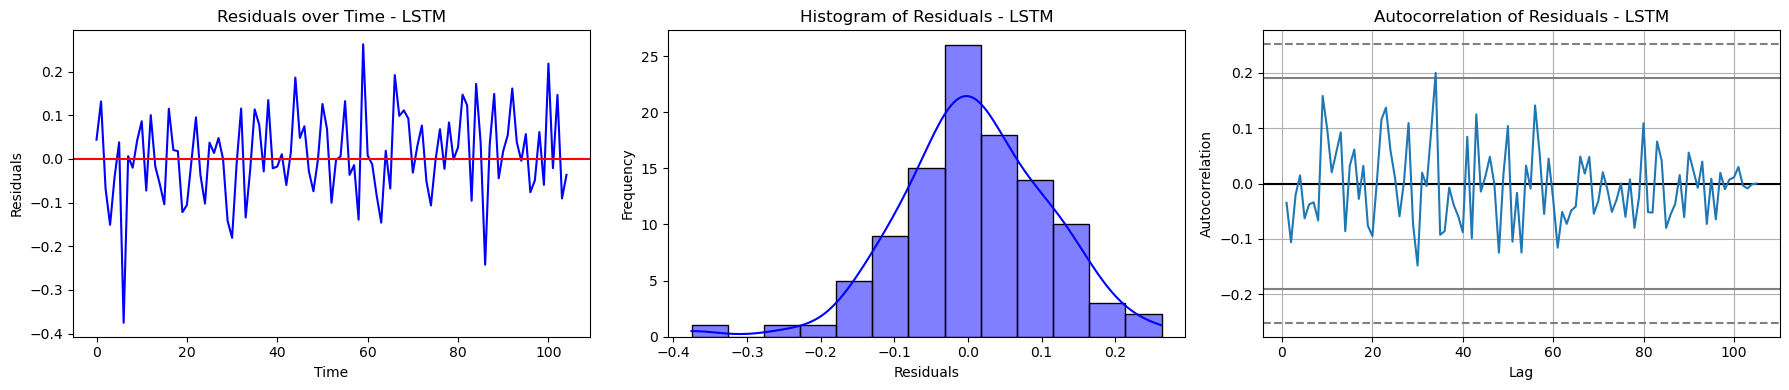

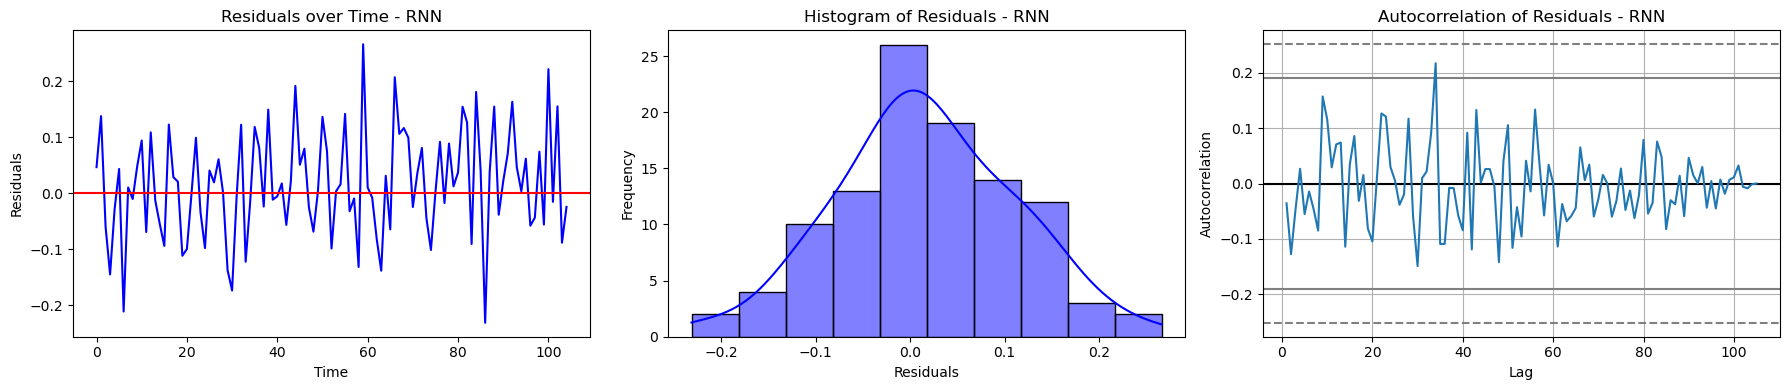

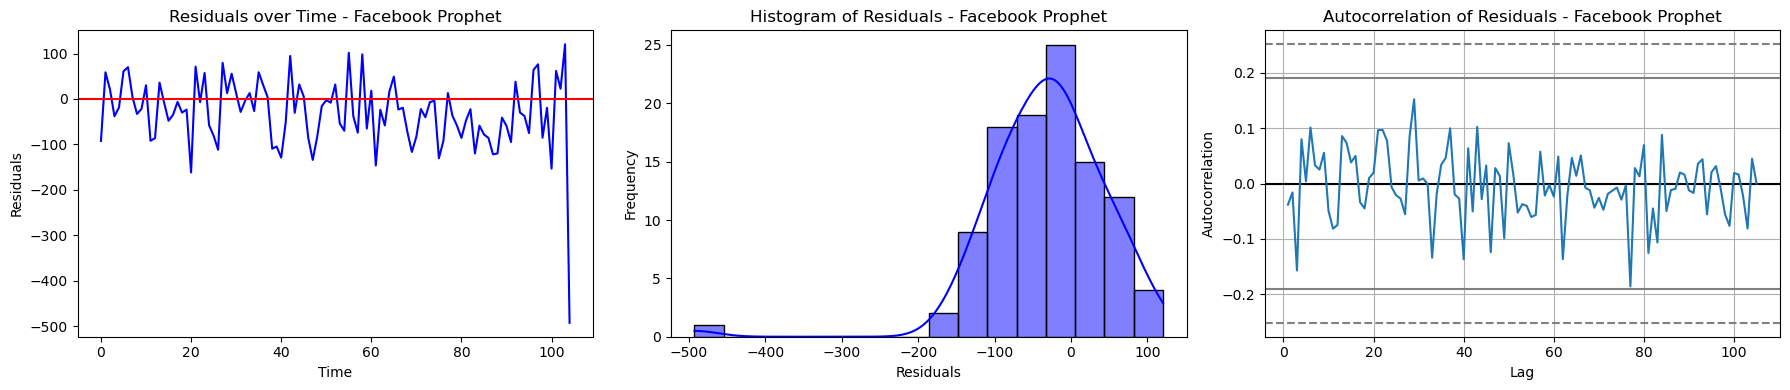

In [93]:
# Assuming 'test_data', 'y_test', and all forecast variables are already defined
analyze_residuals(test_data['Total'], moving_avg_forecast, 'Moving Average')
analyze_residuals(test_data['Total'], exp_forecast, 'Exponential Smoothing')
analyze_residuals(test_data['Total'], arima_predictions, 'ARIMA')
analyze_residuals(test_data['Total'], sarima_predictions, 'SARIMA')
analyze_residuals(test_data['Total'], rf_forecast, 'Random Forest')
analyze_residuals(test_data['Total'], gb_forecast, 'Gradient Boosting')
analyze_residuals(y_test, flattened_lstm_predictions, 'LSTM')
analyze_residuals(y_test, flattened_rnn_predictions, 'RNN')
analyze_residuals(test_data_reset['Total'], forecast['yhat'], 'Facebook Prophet')
